## Dataset

*FER2013* was  introduced  at  the International  Conference  on  Machine  Learning (ICML)  in  2013  and  became  a  benchmark  in comparing  model  performance  in  emotion recognition. Human  performance on  this  dataset is estimated to be 65.5% (Goodfellow et al., 2014).
<br>
<br>
<center>
    <img src="https://www.researchgate.net/profile/Chaudhary-Aqdus/publication/349384285/figure/fig2/AS:1033151476420608@1623333915728/FER-2013-sample-images-for-facial-emotion-recognition.jpg" alt="Attention Augmented Convolutional Networks" width="700"/>
</center>
<br>

The dataset contains 35,887 images (48x48 pixels) in grayscale annotated with different 7 facial expressions (angry, disgust, fear, happy, sad, surpise, neutral). *FER2013* is divided in three subsets: train (28,709), validation (3,589) and test (3,589).

> I.  J.  Goodfellow  et  al.,  *“Challenges  in  representation learning: A report on  three machine learning  contests,”* Neural Networks, vol. 64, 2015, doi: 10.1016/j.neunet.2014.09.005.

## Import

In [1]:
# WARNINGS
import warnings
warnings.filterwarnings("ignore")
# DATA MANIPULATION
import numpy as np
import pandas as pd
from math import ceil
# PLOTS
import seaborn as sns
import matplotlib.pyplot as plt
# DEEPLEARNING
import tensorflow as tf
tf.random.set_seed(42)
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.initializers import  RandomNormal
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.metrics import SparseCategoricalAccuracy
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from keras.models import load_model
from convVariants import AAConv, ChannelAttention, SpatialAttention, DropBlock2D
# GRADCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm

## Functions

In [2]:
# This function create a data generator
def get_datagen(dataset, aug=False, shuf=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='grayscale',
            class_mode='sparse',
            shuffle = shuf,
            batch_size=128)

In [3]:
# This function will plot images in the form of a grid.
def plotImages(images_arr, labels, labels_dict):
    labels_dict = dict(zip(labels_dict.values(), labels_dict.keys()))
    fig, axes = plt.subplots(1,len(images_arr), figsize=(10,10))
    for img, ax, label in zip(images_arr, axes, labels):
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_title(labels_dict[int(label)])
    plt.tight_layout()
    plt.show()

In [4]:
# This function will compute the class frequency of a set.
def get_class_count(data, labels_dict):
    labels_map = dict(zip(labels_dict.values(), labels_dict.keys()))
    count = pd.Series(data.classes).map(labels_map).value_counts()
    return count

In [5]:
# This function will plot the model history.
def plotHistory(model_history):
    sns.set_theme()
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    axes[0].set_title("Model Loss")
    axes[0].plot(model_history.history['loss'], label='train')
    axes[0].plot(model_history.history['val_loss'], label='test')
    axes[0].set(ylabel="Loss", xlabel="Epoch")
    axes[0].legend()
    axes[1].set_title("Model Accuracy")
    axes[1].plot(model_history.history['sparse_categorical_accuracy'], label='train')
    axes[1].plot(model_history.history['val_sparse_categorical_accuracy'], label='test')
    axes[1].set(ylabel="Accuracy", xlabel="Epoch")
    axes[1].legend()
    plt.show()

In [6]:
# This function will plot the confusion matrix (both normalized and absolute).
def plot_confusion_matrix(true, predicted, labels):
    
    cm = confusion_matrix(true, predicted)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.set(color_codes=True)
    sns.set(font_scale=0.8)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    axes[0].set_title("Confusion Matrix [Normalized]")
    sns.heatmap(cm_normalized, annot=True, linewidths = 0.01, cbar_kws={'label': 'Scale'}, fmt='.2f', ax=axes[0], vmin=0, vmax=1)
    axes[0].set_xticklabels(labels)
    axes[0].set_yticklabels(labels)
    axes[0].set(ylabel="True Label", xlabel="Predicted Label")
    axes[1].set_title("Confusion Matrix [Frequency]")
    axes[1] = sns.heatmap(cm, annot=True, linewidths = 0.01, cbar_kws={'label': 'Scale'}, fmt='d', ax=axes[1])
    axes[1].set_xticklabels(labels)
    axes[1].set_yticklabels(labels)
    axes[1].set(ylabel="True Label", xlabel="Predicted Label")

    plt.show()

In [7]:
# This function will compute the class weight
def getWeights(dataset):
    w = class_weight.compute_class_weight('balanced',classes = np.unique(dataset.classes), y = dataset.classes)
    class_weights = dict(zip(range(len(w)),w))
    return class_weights

In [8]:
# This function will generate the titles for the gradcam
def makeTitle(y_pred, y_test, class_names_dict):
    y_pred = np.vectorize(class_names_dict.get)(y_pred)
    y_test = np.vectorize(class_names_dict.get)(y_test)
    
    titles = []
    for i in range(len(y_test)):
        titles.append(('Predicted: {} \nActual: {}'.format(y_pred[i],y_test[i]), y_pred[i]==y_test[i]))
    return titles

## Loading the dataset

In [9]:
DATASET = 'FER2013'

train_it = get_datagen('Datasets/'+DATASET+'/Train', aug=True, shuf=True)
val_it = get_datagen('Datasets/'+DATASET+'/Validation', aug=False, shuf=False)
test_it = get_datagen('Datasets/'+DATASET+'/Test', aug=False, shuf=False)

class_dict = train_it.class_indices

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## Exploring the dataset

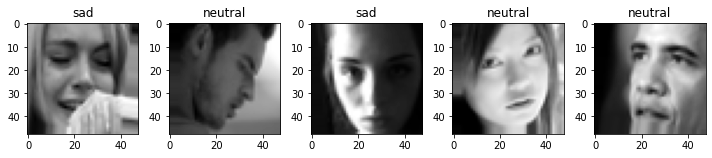

In [10]:
sample_training_images, sample_training_labels = next(train_it)
plotImages(sample_training_images[:5], sample_training_labels[:5], class_dict)

In [11]:
print('Training set:')
display(get_class_count(train_it, class_dict))
print('Total:', len(train_it.classes))
print('\nValidation set:')
display(get_class_count(val_it, class_dict))
print('Total:', len(val_it.classes))
print('\nTest set:')
display(get_class_count(test_it, class_dict))
print('Total:', len(test_it.classes))

Training set:


happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
dtype: int64

Total: 28709

Validation set:


happy       879
neutral     626
sad         594
fear        528
angry       491
surprise    416
disgust      55
dtype: int64

Total: 3589

Test set:


happy       895
sad         653
neutral     607
fear        496
angry       467
surprise    415
disgust      56
dtype: int64

Total: 3589


## Models and training

In [12]:
EPOCHS = 250
N_CLASSES = len(train_it.class_indices)

## Simple CNN model

### Five-Layer Model [Kazada et al., 2020]

> Khanzada, A., Bai, C., & Celepcikay, F. T. (2020). *Facial expression recognition with deep learning.* arXiv preprint arXiv:2004.11823. https://arxiv.org/pdf/2004.11823.pdf

#### Without Class Weights

##### Metrics, loss, optimizer and checkpoints

In [13]:
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaCNN_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [14]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='Kazada')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name="CONV3"))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "Kazada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 BATCHNORM2 (BatchNormalizat  (None, 23, 23, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 11, 11, 32)        0    

##### Training

In [15]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 1.8704 - sparse_categorical_accuracy: 0.3248
Epoch 1: val_loss improved from inf to 2.86879, saving model to Models/FER2013\KazadaCNN_best.h5
225/225 [==============================] - 26s 94ms/step - loss: 1.8704 - sparse_categorical_accuracy: 0.3248 - val_loss: 2.8688 - val_sparse_categorical_accuracy: 0.1700
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.5109 - sparse_categorical_accuracy: 0.4271
Epoch 2: val_loss improved from 2.86879 to 1.71052, saving model to Models/FER2013\KazadaCNN_best.h5
225/225 [==============================] - 20s 87ms/step - loss: 1.5109 - sparse_categorical_accuracy: 0.4271 - val_loss: 1.7105 - val_sparse_categorical_accuracy: 0.3600
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.3645 - sparse_categorical_accuracy: 0.4802
Epoch 3: val_loss improved from 1.71052 to 1.35541, saving model to Models/FER2013\KazadaCNN_best.h5
225/225 [==

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 0.9831 - sparse_categorical_accuracy: 0.6288
Epoch 24: val_loss did not improve from 1.02645
225/225 [==============================] - 20s 87ms/step - loss: 0.9831 - sparse_categorical_accuracy: 0.6288 - val_loss: 1.0781 - val_sparse_categorical_accuracy: 0.6063
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 0.9747 - sparse_categorical_accuracy: 0.6303
Epoch 25: val_loss did not improve from 1.02645
225/225 [==============================] - 20s 87ms/step - loss: 0.9747 - sparse_categorical_accuracy: 0.6303 - val_loss: 1.0457 - val_sparse_categorical_accuracy: 0.6230
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 0.9652 - sparse_categorical_accuracy: 0.6358
Epoch 26: val_loss did not improve from 1.02645
225/225 [==============================] - 20s 87ms/step - loss: 0.9652 - sparse_categorical_accuracy: 0.6358 - val_loss: 1.0305 - val_sparse_categorical_accuracy:

225/225 [==============================] - ETA: 0s - loss: 0.8407 - sparse_categorical_accuracy: 0.6859
Epoch 48: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.8407 - sparse_categorical_accuracy: 0.6859 - val_loss: 1.1073 - val_sparse_categorical_accuracy: 0.6211
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 0.8472 - sparse_categorical_accuracy: 0.6824
Epoch 49: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.8472 - sparse_categorical_accuracy: 0.6824 - val_loss: 1.1346 - val_sparse_categorical_accuracy: 0.6074
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 0.8559 - sparse_categorical_accuracy: 0.6772
Epoch 50: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.8559 - sparse_categorical_accuracy: 0.6772 - val_loss: 1.0816 - val_sparse_categorical_accuracy: 0.6160
Epoch

225/225 [==============================] - 20s 88ms/step - loss: 0.7582 - sparse_categorical_accuracy: 0.7182 - val_loss: 1.1555 - val_sparse_categorical_accuracy: 0.6169
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 0.7514 - sparse_categorical_accuracy: 0.7226
Epoch 73: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 89ms/step - loss: 0.7514 - sparse_categorical_accuracy: 0.7226 - val_loss: 1.0431 - val_sparse_categorical_accuracy: 0.6375
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 0.7575 - sparse_categorical_accuracy: 0.7183
Epoch 74: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.7575 - sparse_categorical_accuracy: 0.7183 - val_loss: 1.0168 - val_sparse_categorical_accuracy: 0.6484
Epoch 75/250
225/225 [==============================] - ETA: 0s - loss: 0.7453 - sparse_categorical_accuracy: 0.7210
Epoch 75: val_loss did not improve from 

Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.6878 - sparse_categorical_accuracy: 0.7470
Epoch 97: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.6878 - sparse_categorical_accuracy: 0.7470 - val_loss: 1.0945 - val_sparse_categorical_accuracy: 0.6311
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 0.6745 - sparse_categorical_accuracy: 0.7477
Epoch 98: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.6745 - sparse_categorical_accuracy: 0.7477 - val_loss: 1.0835 - val_sparse_categorical_accuracy: 0.6333
Epoch 99/250
225/225 [==============================] - ETA: 0s - loss: 0.6650 - sparse_categorical_accuracy: 0.7511
Epoch 99: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.6650 - sparse_categorical_accuracy: 0.7511 - val_loss: 1.0869 - val_sparse_categorical_accuracy:

225/225 [==============================] - ETA: 0s - loss: 0.6174 - sparse_categorical_accuracy: 0.7707
Epoch 121: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.6174 - sparse_categorical_accuracy: 0.7707 - val_loss: 1.1160 - val_sparse_categorical_accuracy: 0.6573
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.6171 - sparse_categorical_accuracy: 0.7705
Epoch 122: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.7705 - val_loss: 1.1956 - val_sparse_categorical_accuracy: 0.6422
Epoch 123/250
225/225 [==============================] - ETA: 0s - loss: 0.6140 - sparse_categorical_accuracy: 0.7716
Epoch 123: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.6140 - sparse_categorical_accuracy: 0.7716 - val_loss: 1.1478 - val_sparse_categorical_accuracy: 0.6420


225/225 [==============================] - ETA: 0s - loss: 0.5781 - sparse_categorical_accuracy: 0.7838
Epoch 145: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.5781 - sparse_categorical_accuracy: 0.7838 - val_loss: 1.1294 - val_sparse_categorical_accuracy: 0.6356
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.5683 - sparse_categorical_accuracy: 0.7890
Epoch 146: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.5683 - sparse_categorical_accuracy: 0.7890 - val_loss: 1.1947 - val_sparse_categorical_accuracy: 0.6275
Epoch 147/250
225/225 [==============================] - ETA: 0s - loss: 0.5684 - sparse_categorical_accuracy: 0.7895
Epoch 147: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.5684 - sparse_categorical_accuracy: 0.7895 - val_loss: 1.1510 - val_sparse_categorical_accuracy: 0.6523


225/225 [==============================] - ETA: 0s - loss: 0.5389 - sparse_categorical_accuracy: 0.7991
Epoch 169: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.5389 - sparse_categorical_accuracy: 0.7991 - val_loss: 1.1350 - val_sparse_categorical_accuracy: 0.6587
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.5445 - sparse_categorical_accuracy: 0.7981
Epoch 170: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.5445 - sparse_categorical_accuracy: 0.7981 - val_loss: 1.1887 - val_sparse_categorical_accuracy: 0.6637
Epoch 171/250
225/225 [==============================] - ETA: 0s - loss: 0.5256 - sparse_categorical_accuracy: 0.8054
Epoch 171: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.5256 - sparse_categorical_accuracy: 0.8054 - val_loss: 1.1366 - val_sparse_categorical_accuracy: 0.6640


225/225 [==============================] - ETA: 0s - loss: 0.5031 - sparse_categorical_accuracy: 0.8154
Epoch 193: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.5031 - sparse_categorical_accuracy: 0.8154 - val_loss: 1.1652 - val_sparse_categorical_accuracy: 0.6598
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.5076 - sparse_categorical_accuracy: 0.8127
Epoch 194: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.5076 - sparse_categorical_accuracy: 0.8127 - val_loss: 1.1370 - val_sparse_categorical_accuracy: 0.6587
Epoch 195/250
225/225 [==============================] - ETA: 0s - loss: 0.5111 - sparse_categorical_accuracy: 0.8115
Epoch 195: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.5111 - sparse_categorical_accuracy: 0.8115 - val_loss: 1.2252 - val_sparse_categorical_accuracy: 0.6517


225/225 [==============================] - ETA: 0s - loss: 0.4826 - sparse_categorical_accuracy: 0.8234
Epoch 217: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.4826 - sparse_categorical_accuracy: 0.8234 - val_loss: 1.2699 - val_sparse_categorical_accuracy: 0.6517
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.4847 - sparse_categorical_accuracy: 0.8214
Epoch 218: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 87ms/step - loss: 0.4847 - sparse_categorical_accuracy: 0.8214 - val_loss: 1.1909 - val_sparse_categorical_accuracy: 0.6548
Epoch 219/250
225/225 [==============================] - ETA: 0s - loss: 0.5032 - sparse_categorical_accuracy: 0.8151
Epoch 219: val_loss did not improve from 1.00819
225/225 [==============================] - 19s 86ms/step - loss: 0.5032 - sparse_categorical_accuracy: 0.8151 - val_loss: 1.2098 - val_sparse_categorical_accuracy: 0.6531


225/225 [==============================] - ETA: 0s - loss: 0.4590 - sparse_categorical_accuracy: 0.8314
Epoch 241: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 89ms/step - loss: 0.4590 - sparse_categorical_accuracy: 0.8314 - val_loss: 1.2754 - val_sparse_categorical_accuracy: 0.6514
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.4634 - sparse_categorical_accuracy: 0.8285
Epoch 242: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 88ms/step - loss: 0.4634 - sparse_categorical_accuracy: 0.8285 - val_loss: 1.3200 - val_sparse_categorical_accuracy: 0.6414
Epoch 243/250
225/225 [==============================] - ETA: 0s - loss: 0.4627 - sparse_categorical_accuracy: 0.8283
Epoch 243: val_loss did not improve from 1.00819
225/225 [==============================] - 20s 89ms/step - loss: 0.4627 - sparse_categorical_accuracy: 0.8283 - val_loss: 1.2530 - val_sparse_categorical_accuracy: 0.6525


##### History and performance

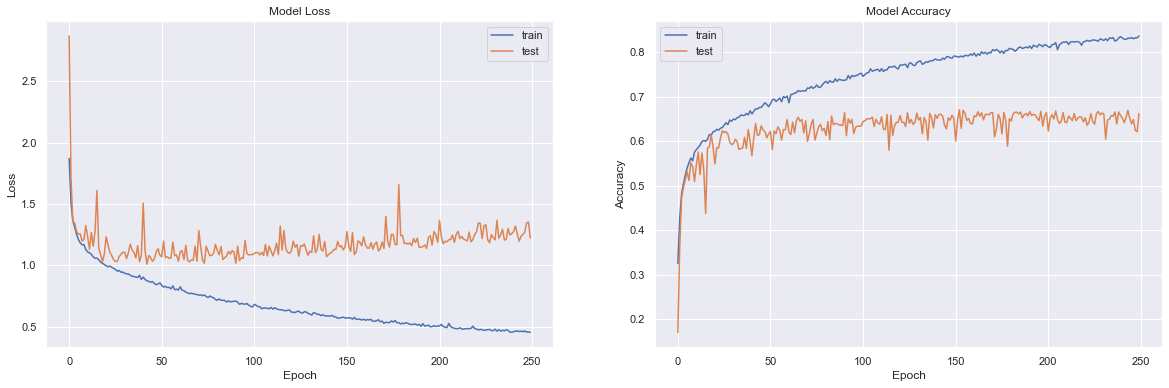

In [16]:
# SHOW HISTORY
plotHistory(history)

In [17]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaCNN_best.h5')
model.evaluate(test_it)

29/29 [==============================] - 1s 41ms/step - loss: 1.0753 - sparse_categorical_accuracy: 0.6169


[1.07530677318573, 0.6168849468231201]

29/29 [==============================] - 1s 38ms/step


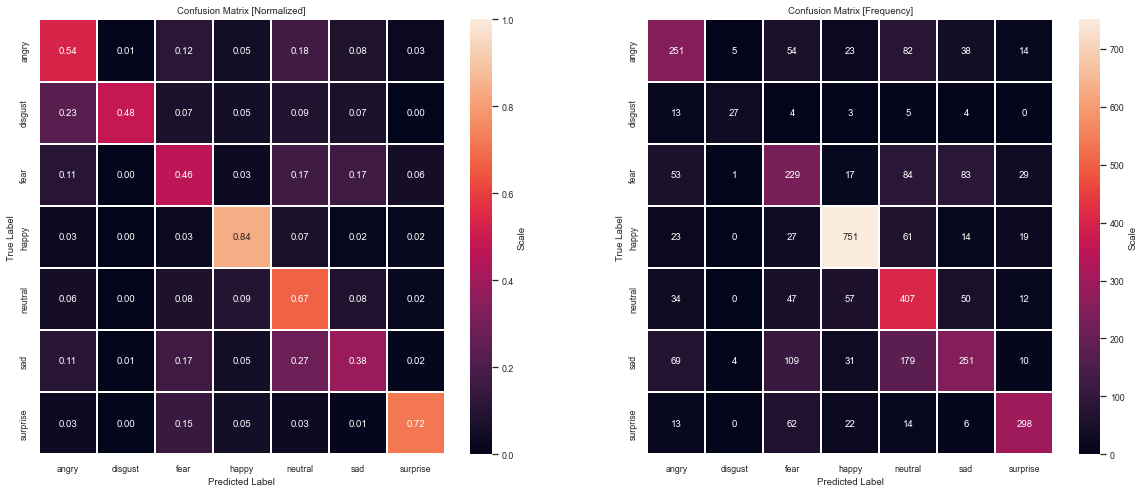

              precision    recall  f1-score   support

       angry       0.55      0.54      0.54       467
     disgust       0.73      0.48      0.58        56
        fear       0.43      0.46      0.45       496
       happy       0.83      0.84      0.83       895
     neutral       0.49      0.67      0.57       607
         sad       0.56      0.38      0.46       653
    surprise       0.78      0.72      0.75       415

    accuracy                           0.62      3589
   macro avg       0.62      0.58      0.60      3589
weighted avg       0.62      0.62      0.61      3589



In [18]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

#### With Class Weights

##### Metrics, loss, optimizer and checkpoints

In [19]:
WEIGHTS = getWeights(train_it)
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaCNN_ClassWeights_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [20]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='Kazada')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name="CONV3"))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "Kazada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 BATCHNORM2 (BatchNormalizat  (None, 23, 23, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 11, 11, 32)        0    

##### Training

In [21]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, class_weight=WEIGHTS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 2.0637 - sparse_categorical_accuracy: 0.2463
Epoch 1: val_loss improved from inf to 2.36070, saving model to Models/FER2013\KazadaCNN_ClassWeights_best.h5
225/225 [==============================] - 21s 88ms/step - loss: 2.0637 - sparse_categorical_accuracy: 0.2463 - val_loss: 2.3607 - val_sparse_categorical_accuracy: 0.1744
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.7285 - sparse_categorical_accuracy: 0.3375
Epoch 2: val_loss improved from 2.36070 to 1.66142, saving model to Models/FER2013\KazadaCNN_ClassWeights_best.h5
225/225 [==============================] - 19s 86ms/step - loss: 1.7285 - sparse_categorical_accuracy: 0.3375 - val_loss: 1.6614 - val_sparse_categorical_accuracy: 0.3550
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.6041 - sparse_categorical_accuracy: 0.3873
Epoch 3: val_loss did not improve from 1.66142
225/225 [==============================

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.0647 - sparse_categorical_accuracy: 0.5769
Epoch 24: val_loss did not improve from 1.13850
225/225 [==============================] - 19s 85ms/step - loss: 1.0647 - sparse_categorical_accuracy: 0.5769 - val_loss: 1.2353 - val_sparse_categorical_accuracy: 0.5573
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.0561 - sparse_categorical_accuracy: 0.5810
Epoch 25: val_loss improved from 1.13850 to 1.12793, saving model to Models/FER2013\KazadaCNN_ClassWeights_best.h5
225/225 [==============================] - 19s 86ms/step - loss: 1.0561 - sparse_categorical_accuracy: 0.5810 - val_loss: 1.1279 - val_sparse_categorical_accuracy: 0.5740
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.0396 - sparse_categorical_accuracy: 0.5885
Epoch 26: val_loss did not improve from 1.12793
225/225 [==============================] - 19s 85ms/step - loss: 1.0396 - sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.9223 - sparse_categorical_accuracy: 0.6228
Epoch 47: val_loss did not improve from 1.06439
225/225 [==============================] - 19s 86ms/step - loss: 0.9223 - sparse_categorical_accuracy: 0.6228 - val_loss: 1.0743 - val_sparse_categorical_accuracy: 0.6127
Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 0.9028 - sparse_categorical_accuracy: 0.6289
Epoch 48: val_loss did not improve from 1.06439
225/225 [==============================] - 19s 86ms/step - loss: 0.9028 - sparse_categorical_accuracy: 0.6289 - val_loss: 1.0848 - val_sparse_categorical_accuracy: 0.6144
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 0.9147 - sparse_categorical_accuracy: 0.6296
Epoch 49: val_loss did not improve from 1.06439
225/225 [==============================] - 19s 86ms/step - loss: 0.9147 - sparse_categorical_accuracy: 0.6296 - val_loss: 1.0712 - val_sparse_categorical_accuracy: 0.6116
Epoch

225/225 [==============================] - ETA: 0s - loss: 0.8183 - sparse_categorical_accuracy: 0.6623
Epoch 70: val_loss did not improve from 1.01654
225/225 [==============================] - 19s 86ms/step - loss: 0.8183 - sparse_categorical_accuracy: 0.6623 - val_loss: 1.1008 - val_sparse_categorical_accuracy: 0.6094
Epoch 71/250
225/225 [==============================] - ETA: 0s - loss: 0.8099 - sparse_categorical_accuracy: 0.6657
Epoch 71: val_loss did not improve from 1.01654
225/225 [==============================] - 19s 86ms/step - loss: 0.8099 - sparse_categorical_accuracy: 0.6657 - val_loss: 1.1062 - val_sparse_categorical_accuracy: 0.6110
Epoch 72/250
225/225 [==============================] - ETA: 0s - loss: 0.8131 - sparse_categorical_accuracy: 0.6659
Epoch 72: val_loss did not improve from 1.01654
225/225 [==============================] - 19s 86ms/step - loss: 0.8131 - sparse_categorical_accuracy: 0.6659 - val_loss: 1.1417 - val_sparse_categorical_accuracy: 0.6208
Epoch

225/225 [==============================] - 19s 86ms/step - loss: 0.7954 - sparse_categorical_accuracy: 0.6759 - val_loss: 1.1231 - val_sparse_categorical_accuracy: 0.6063
Epoch 95/250
225/225 [==============================] - ETA: 0s - loss: 0.7647 - sparse_categorical_accuracy: 0.6855
Epoch 95: val_loss did not improve from 1.01654
225/225 [==============================] - 19s 85ms/step - loss: 0.7647 - sparse_categorical_accuracy: 0.6855 - val_loss: 1.0235 - val_sparse_categorical_accuracy: 0.6450
Epoch 96/250
225/225 [==============================] - ETA: 0s - loss: 0.7590 - sparse_categorical_accuracy: 0.6849
Epoch 96: val_loss did not improve from 1.01654
225/225 [==============================] - 19s 86ms/step - loss: 0.7590 - sparse_categorical_accuracy: 0.6849 - val_loss: 1.0627 - val_sparse_categorical_accuracy: 0.6244
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.7650 - sparse_categorical_accuracy: 0.6843
Epoch 97: val_loss did not improve from 

Epoch 119/250
225/225 [==============================] - ETA: 0s - loss: 0.6826 - sparse_categorical_accuracy: 0.7152
Epoch 119: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 91ms/step - loss: 0.6826 - sparse_categorical_accuracy: 0.7152 - val_loss: 1.0502 - val_sparse_categorical_accuracy: 0.6447
Epoch 120/250
225/225 [==============================] - ETA: 0s - loss: 0.6791 - sparse_categorical_accuracy: 0.7204
Epoch 120: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 88ms/step - loss: 0.6791 - sparse_categorical_accuracy: 0.7204 - val_loss: 1.2575 - val_sparse_categorical_accuracy: 0.5938
Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.6842 - sparse_categorical_accuracy: 0.7167
Epoch 121: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 88ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.7167 - val_loss: 1.0623 - val_sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.6487 - sparse_categorical_accuracy: 0.7327
Epoch 143: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.6487 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0963 - val_sparse_categorical_accuracy: 0.6553
Epoch 144/250
225/225 [==============================] - ETA: 0s - loss: 0.6364 - sparse_categorical_accuracy: 0.7373
Epoch 144: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.6364 - sparse_categorical_accuracy: 0.7373 - val_loss: 1.1225 - val_sparse_categorical_accuracy: 0.6411
Epoch 145/250
225/225 [==============================] - ETA: 0s - loss: 0.6470 - sparse_categorical_accuracy: 0.7340
Epoch 145: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.6470 - sparse_categorical_accuracy: 0.7340 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.6539


225/225 [==============================] - ETA: 0s - loss: 0.5952 - sparse_categorical_accuracy: 0.7521
Epoch 167: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 90ms/step - loss: 0.5952 - sparse_categorical_accuracy: 0.7521 - val_loss: 1.0769 - val_sparse_categorical_accuracy: 0.6606
Epoch 168/250
225/225 [==============================] - ETA: 0s - loss: 0.5990 - sparse_categorical_accuracy: 0.7475
Epoch 168: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.5990 - sparse_categorical_accuracy: 0.7475 - val_loss: 1.0795 - val_sparse_categorical_accuracy: 0.6542
Epoch 169/250
225/225 [==============================] - ETA: 0s - loss: 0.6112 - sparse_categorical_accuracy: 0.7456
Epoch 169: val_loss did not improve from 1.01654
225/225 [==============================] - 19s 86ms/step - loss: 0.6112 - sparse_categorical_accuracy: 0.7456 - val_loss: 1.1287 - val_sparse_categorical_accuracy: 0.6567


225/225 [==============================] - ETA: 0s - loss: 0.5532 - sparse_categorical_accuracy: 0.7669
Epoch 191: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 89ms/step - loss: 0.5532 - sparse_categorical_accuracy: 0.7669 - val_loss: 1.1263 - val_sparse_categorical_accuracy: 0.6467
Epoch 192/250
225/225 [==============================] - ETA: 0s - loss: 0.5465 - sparse_categorical_accuracy: 0.7739
Epoch 192: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.5465 - sparse_categorical_accuracy: 0.7739 - val_loss: 1.1378 - val_sparse_categorical_accuracy: 0.6542
Epoch 193/250
225/225 [==============================] - ETA: 0s - loss: 0.5537 - sparse_categorical_accuracy: 0.7695
Epoch 193: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.5537 - sparse_categorical_accuracy: 0.7695 - val_loss: 1.0869 - val_sparse_categorical_accuracy: 0.6562


225/225 [==============================] - ETA: 0s - loss: 0.5352 - sparse_categorical_accuracy: 0.7790
Epoch 215: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 89ms/step - loss: 0.5352 - sparse_categorical_accuracy: 0.7790 - val_loss: 1.1647 - val_sparse_categorical_accuracy: 0.6673
Epoch 216/250
225/225 [==============================] - ETA: 0s - loss: 0.5291 - sparse_categorical_accuracy: 0.7809
Epoch 216: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 88ms/step - loss: 0.5291 - sparse_categorical_accuracy: 0.7809 - val_loss: 1.1677 - val_sparse_categorical_accuracy: 0.6620
Epoch 217/250
225/225 [==============================] - ETA: 0s - loss: 0.5364 - sparse_categorical_accuracy: 0.7784
Epoch 217: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.5364 - sparse_categorical_accuracy: 0.7784 - val_loss: 1.1378 - val_sparse_categorical_accuracy: 0.6584


225/225 [==============================] - ETA: 0s - loss: 0.4972 - sparse_categorical_accuracy: 0.7970
Epoch 239: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 89ms/step - loss: 0.4972 - sparse_categorical_accuracy: 0.7970 - val_loss: 1.3236 - val_sparse_categorical_accuracy: 0.6431
Epoch 240/250
225/225 [==============================] - ETA: 0s - loss: 0.5228 - sparse_categorical_accuracy: 0.7843
Epoch 240: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 87ms/step - loss: 0.5228 - sparse_categorical_accuracy: 0.7843 - val_loss: 1.1923 - val_sparse_categorical_accuracy: 0.6567
Epoch 241/250
225/225 [==============================] - ETA: 0s - loss: 0.5154 - sparse_categorical_accuracy: 0.7891
Epoch 241: val_loss did not improve from 1.01654
225/225 [==============================] - 20s 88ms/step - loss: 0.5154 - sparse_categorical_accuracy: 0.7891 - val_loss: 1.1811 - val_sparse_categorical_accuracy: 0.6581


##### History and performance

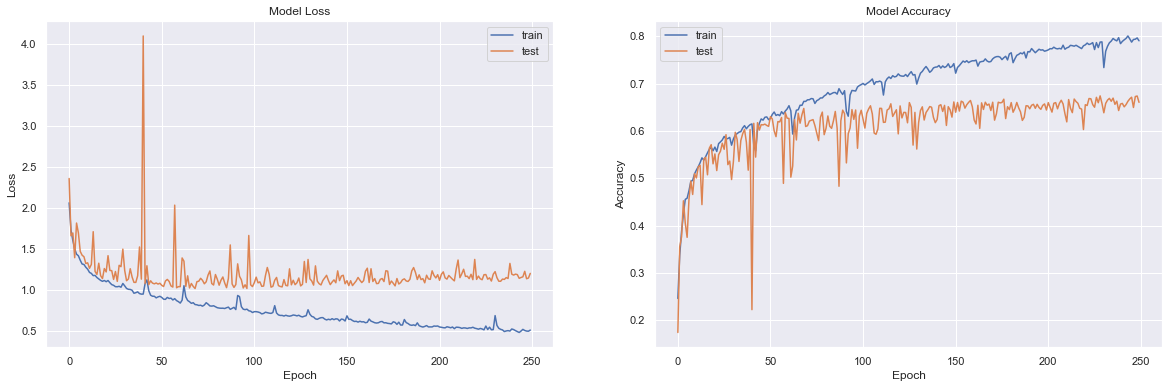

In [22]:
# SHOW HISTORY
plotHistory(history)

In [23]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaCNN_ClassWeights_best.h5')
model.evaluate(test_it)

29/29 [==============================] - 1s 41ms/step - loss: 1.0438 - sparse_categorical_accuracy: 0.6225


[1.0438281297683716, 0.6224575042724609]

29/29 [==============================] - 1s 38ms/step


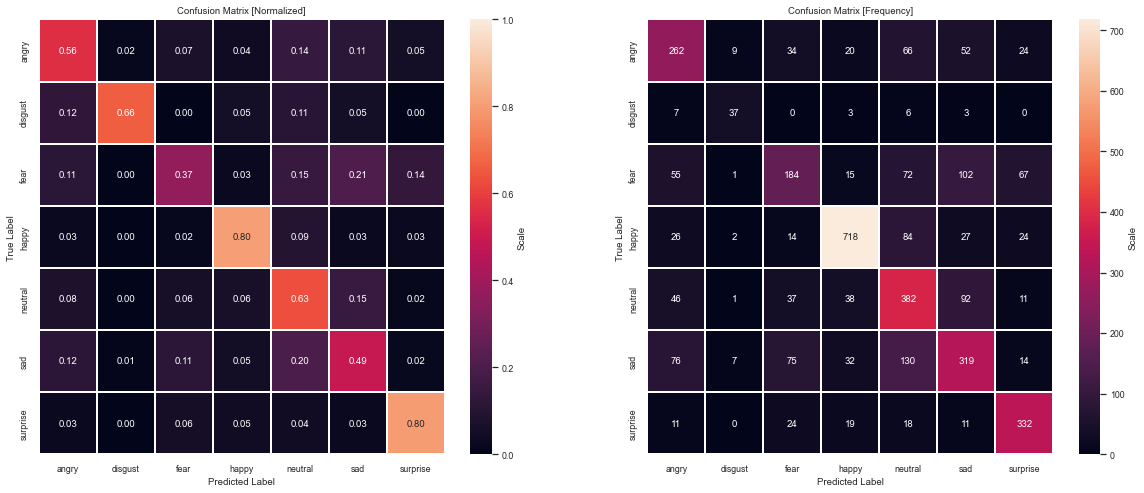

              precision    recall  f1-score   support

       angry       0.54      0.56      0.55       467
     disgust       0.65      0.66      0.65        56
        fear       0.50      0.37      0.43       496
       happy       0.85      0.80      0.83       895
     neutral       0.50      0.63      0.56       607
         sad       0.53      0.49      0.51       653
    surprise       0.70      0.80      0.75       415

    accuracy                           0.62      3589
   macro avg       0.61      0.62      0.61      3589
weighted avg       0.62      0.62      0.62      3589



In [24]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

## Variants with Attention

### Simple CNN model + Attention Augmented Convolutional Networks

> Bello, I., Zoph, B., Vaswani, A., Shlens, J., & Le, Q. V. (2019). *Attention augmented convolutional networks.* In Proceedings of the IEEE/CVF international conference on computer vision (pp. 3286-3295).

<center>
    <img src="https://i.imgur.com/b37Wvsx.png" alt="Attention Augmented Convolutional Networks" width="700"/>
</center>

#### Without Class Weights

##### Metrics, loss, optimizer and checkpoints

In [25]:
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaANN_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [26]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaANN')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3 (ATTENTION AUGMENTED VARIANT)
model.add(AAConv(channels_out=64, kernel_size=(5,5), activation='relu',num_heads=4 , depth_k=4, depth_v=4, name="CONV3AA"))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 BATCHNORM2 (BatchNormalizat  (None, 23, 23, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 11, 11, 32)        0 

##### Training

In [27]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 1.8739 - sparse_categorical_accuracy: 0.2980
Epoch 1: val_loss improved from inf to 1.90016, saving model to Models/FER2013\KazadaANN_best.h5
225/225 [==============================] - 26s 108ms/step - loss: 1.8739 - sparse_categorical_accuracy: 0.2980 - val_loss: 1.9002 - val_sparse_categorical_accuracy: 0.2499
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.5585 - sparse_categorical_accuracy: 0.4054
Epoch 2: val_loss improved from 1.90016 to 1.64000, saving model to Models/FER2013\KazadaANN_best.h5
225/225 [==============================] - 21s 94ms/step - loss: 1.5585 - sparse_categorical_accuracy: 0.4054 - val_loss: 1.6400 - val_sparse_categorical_accuracy: 0.3664
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.4217 - sparse_categorical_accuracy: 0.4564
Epoch 3: val_loss improved from 1.64000 to 1.42881, saving model to Models/FER2013\KazadaANN_best.h5
225/225 [=

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.0767 - sparse_categorical_accuracy: 0.5932
Epoch 24: val_loss did not improve from 1.04759
225/225 [==============================] - 20s 87ms/step - loss: 1.0767 - sparse_categorical_accuracy: 0.5932 - val_loss: 1.0865 - val_sparse_categorical_accuracy: 0.5862
Epoch 25/250
224/225 [============================>.] - ETA: 0s - loss: 1.0641 - sparse_categorical_accuracy: 0.5972
Epoch 25: val_loss did not improve from 1.04759
225/225 [==============================] - 20s 89ms/step - loss: 1.0640 - sparse_categorical_accuracy: 0.5972 - val_loss: 1.0689 - val_sparse_categorical_accuracy: 0.6155
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.0501 - sparse_categorical_accuracy: 0.6040
Epoch 26: val_loss did not improve from 1.04759
225/225 [==============================] - 20s 90ms/step - loss: 1.0501 - sparse_categorical_accuracy: 0.6040 - val_loss: 1.0949 - val_sparse_categorical_accuracy:

225/225 [==============================] - ETA: 0s - loss: 0.9368 - sparse_categorical_accuracy: 0.6471
Epoch 48: val_loss improved from 1.01305 to 0.99417, saving model to Models/FER2013\KazadaANN_best.h5
225/225 [==============================] - 20s 87ms/step - loss: 0.9368 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.9942 - val_sparse_categorical_accuracy: 0.6344
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 0.9788 - sparse_categorical_accuracy: 0.6296
Epoch 49: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 88ms/step - loss: 0.9788 - sparse_categorical_accuracy: 0.6296 - val_loss: 1.1668 - val_sparse_categorical_accuracy: 0.5681
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 0.9285 - sparse_categorical_accuracy: 0.6512
Epoch 50: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 91ms/step - loss: 0.9285 - sparse_categorical_accuracy: 0.6512 - val_loss: 

225/225 [==============================] - ETA: 0s - loss: 0.8224 - sparse_categorical_accuracy: 0.6935
Epoch 72: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 88ms/step - loss: 0.8224 - sparse_categorical_accuracy: 0.6935 - val_loss: 1.0161 - val_sparse_categorical_accuracy: 0.6333
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 0.8146 - sparse_categorical_accuracy: 0.6980
Epoch 73: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 88ms/step - loss: 0.8146 - sparse_categorical_accuracy: 0.6980 - val_loss: 1.0080 - val_sparse_categorical_accuracy: 0.6417
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 0.8116 - sparse_categorical_accuracy: 0.6945
Epoch 74: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 90ms/step - loss: 0.8116 - sparse_categorical_accuracy: 0.6945 - val_loss: 1.3608 - val_sparse_categorical_accuracy: 0.5737
Epoch

225/225 [==============================] - 20s 89ms/step - loss: 0.7086 - sparse_categorical_accuracy: 0.7389 - val_loss: 1.1349 - val_sparse_categorical_accuracy: 0.6272
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.6901 - sparse_categorical_accuracy: 0.7436
Epoch 97: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 90ms/step - loss: 0.6901 - sparse_categorical_accuracy: 0.7436 - val_loss: 1.0442 - val_sparse_categorical_accuracy: 0.6495
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 0.6889 - sparse_categorical_accuracy: 0.7491
Epoch 98: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 88ms/step - loss: 0.6889 - sparse_categorical_accuracy: 0.7491 - val_loss: 1.0968 - val_sparse_categorical_accuracy: 0.6431
Epoch 99/250
225/225 [==============================] - ETA: 0s - loss: 0.6933 - sparse_categorical_accuracy: 0.7430
Epoch 99: val_loss did not improve from 

Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.6168 - sparse_categorical_accuracy: 0.7729
Epoch 121: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 91ms/step - loss: 0.6168 - sparse_categorical_accuracy: 0.7729 - val_loss: 1.0800 - val_sparse_categorical_accuracy: 0.6556
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.6067 - sparse_categorical_accuracy: 0.7767
Epoch 122: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 90ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.7767 - val_loss: 1.1927 - val_sparse_categorical_accuracy: 0.6216
Epoch 123/250
225/225 [==============================] - ETA: 0s - loss: 0.6008 - sparse_categorical_accuracy: 0.7772
Epoch 123: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 90ms/step - loss: 0.6008 - sparse_categorical_accuracy: 0.7772 - val_loss: 1.1414 - val_sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.5530 - sparse_categorical_accuracy: 0.7970
Epoch 145: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.5530 - sparse_categorical_accuracy: 0.7970 - val_loss: 1.1804 - val_sparse_categorical_accuracy: 0.6358
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.5337 - sparse_categorical_accuracy: 0.8054
Epoch 146: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.5337 - sparse_categorical_accuracy: 0.8054 - val_loss: 1.2258 - val_sparse_categorical_accuracy: 0.6077
Epoch 147/250
225/225 [==============================] - ETA: 0s - loss: 0.5299 - sparse_categorical_accuracy: 0.8039
Epoch 147: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.5299 - sparse_categorical_accuracy: 0.8039 - val_loss: 1.1530 - val_sparse_categorical_accuracy: 0.6447


225/225 [==============================] - ETA: 0s - loss: 0.4797 - sparse_categorical_accuracy: 0.8239
Epoch 169: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.4797 - sparse_categorical_accuracy: 0.8239 - val_loss: 1.2954 - val_sparse_categorical_accuracy: 0.6528
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.4857 - sparse_categorical_accuracy: 0.8234
Epoch 170: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.4857 - sparse_categorical_accuracy: 0.8234 - val_loss: 1.2812 - val_sparse_categorical_accuracy: 0.6445
Epoch 171/250
225/225 [==============================] - ETA: 0s - loss: 0.4912 - sparse_categorical_accuracy: 0.8206
Epoch 171: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.4912 - sparse_categorical_accuracy: 0.8206 - val_loss: 1.3205 - val_sparse_categorical_accuracy: 0.6500


225/225 [==============================] - ETA: 0s - loss: 0.4526 - sparse_categorical_accuracy: 0.8359
Epoch 193: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.4526 - sparse_categorical_accuracy: 0.8359 - val_loss: 1.1916 - val_sparse_categorical_accuracy: 0.6604
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.4321 - sparse_categorical_accuracy: 0.8405
Epoch 194: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 86ms/step - loss: 0.4321 - sparse_categorical_accuracy: 0.8405 - val_loss: 1.2356 - val_sparse_categorical_accuracy: 0.6573
Epoch 195/250
225/225 [==============================] - ETA: 0s - loss: 0.4208 - sparse_categorical_accuracy: 0.8475
Epoch 195: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 87ms/step - loss: 0.4208 - sparse_categorical_accuracy: 0.8475 - val_loss: 1.2290 - val_sparse_categorical_accuracy: 0.6434


225/225 [==============================] - ETA: 0s - loss: 0.3996 - sparse_categorical_accuracy: 0.8572
Epoch 217: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.3996 - sparse_categorical_accuracy: 0.8572 - val_loss: 1.2955 - val_sparse_categorical_accuracy: 0.6539
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.4077 - sparse_categorical_accuracy: 0.8509
Epoch 218: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 87ms/step - loss: 0.4077 - sparse_categorical_accuracy: 0.8509 - val_loss: 1.2884 - val_sparse_categorical_accuracy: 0.6475
Epoch 219/250
225/225 [==============================] - ETA: 0s - loss: 0.3992 - sparse_categorical_accuracy: 0.8549
Epoch 219: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.3992 - sparse_categorical_accuracy: 0.8549 - val_loss: 1.3592 - val_sparse_categorical_accuracy: 0.6539


225/225 [==============================] - ETA: 0s - loss: 0.3743 - sparse_categorical_accuracy: 0.8637
Epoch 241: val_loss did not improve from 0.99417
225/225 [==============================] - 19s 86ms/step - loss: 0.3743 - sparse_categorical_accuracy: 0.8637 - val_loss: 1.5626 - val_sparse_categorical_accuracy: 0.5977
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.3549 - sparse_categorical_accuracy: 0.8733
Epoch 242: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 87ms/step - loss: 0.3549 - sparse_categorical_accuracy: 0.8733 - val_loss: 1.3519 - val_sparse_categorical_accuracy: 0.6484
Epoch 243/250
225/225 [==============================] - ETA: 0s - loss: 0.3536 - sparse_categorical_accuracy: 0.8717
Epoch 243: val_loss did not improve from 0.99417
225/225 [==============================] - 20s 88ms/step - loss: 0.3536 - sparse_categorical_accuracy: 0.8717 - val_loss: 1.3672 - val_sparse_categorical_accuracy: 0.6372


##### History and performance

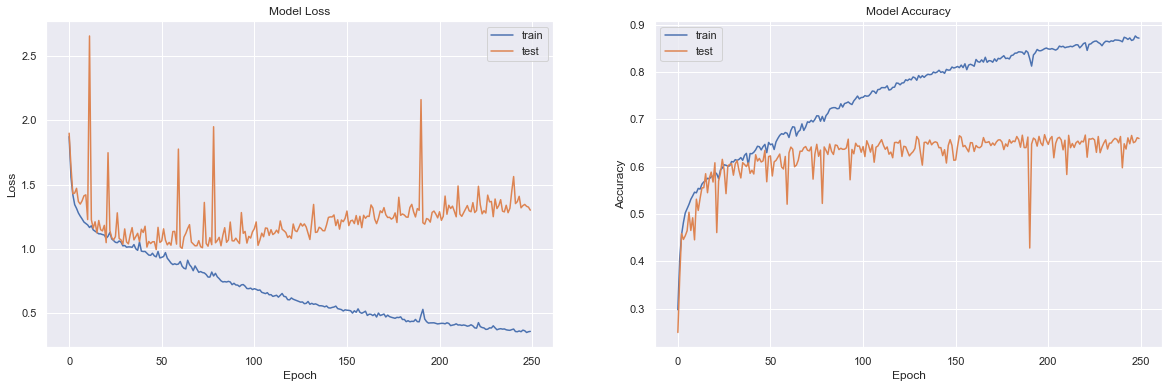

In [28]:
# SHOW HISTORY
plotHistory(history)

In [29]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaANN_best.h5', custom_objects={'AAConv': AAConv})
model.evaluate(test_it)

29/29 [==============================] - 1s 41ms/step - loss: 1.0580 - sparse_categorical_accuracy: 0.6205


[1.0579688549041748, 0.6205071210861206]

29/29 [==============================] - 1s 38ms/step


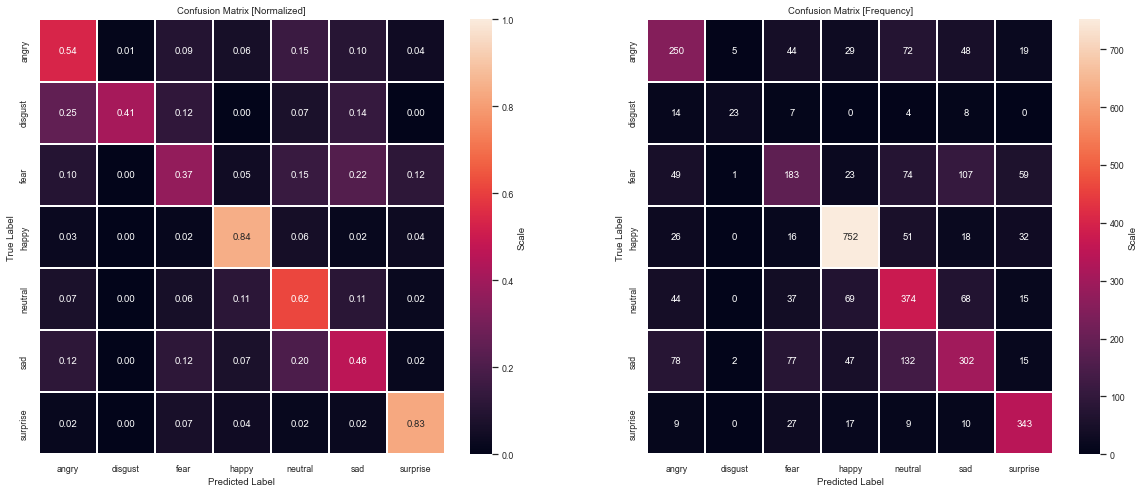

              precision    recall  f1-score   support

       angry       0.53      0.54      0.53       467
     disgust       0.74      0.41      0.53        56
        fear       0.47      0.37      0.41       496
       happy       0.80      0.84      0.82       895
     neutral       0.52      0.62      0.57       607
         sad       0.54      0.46      0.50       653
    surprise       0.71      0.83      0.76       415

    accuracy                           0.62      3589
   macro avg       0.62      0.58      0.59      3589
weighted avg       0.61      0.62      0.61      3589



In [30]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

#### With Class Weights

##### Metrics, loss, optimizer and checkpoints

In [31]:
WEIGHTS = getWeights(train_it)
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaANN_ClassWeights_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [32]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaANN')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3 (ATTENTION AUGMENTED VARIANT)
model.add(AAConv(channels_out=64, kernel_size=(5,5), activation='relu',num_heads=4 , depth_k=4, depth_v=4, name="CONV3AA"))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 BATCHNORM2 (BatchNormalizat  (None, 23, 23, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 11, 11, 32)        0 

##### Training

In [33]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, class_weight=WEIGHTS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 2.0300 - sparse_categorical_accuracy: 0.2253
Epoch 1: val_loss improved from inf to 2.02197, saving model to Models/FER2013\KazadaANN_ClassWeights_best.h5
225/225 [==============================] - 21s 88ms/step - loss: 2.0300 - sparse_categorical_accuracy: 0.2253 - val_loss: 2.0220 - val_sparse_categorical_accuracy: 0.1558
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.7958 - sparse_categorical_accuracy: 0.3009
Epoch 2: val_loss did not improve from 2.02197
225/225 [==============================] - 20s 87ms/step - loss: 1.7958 - sparse_categorical_accuracy: 0.3009 - val_loss: 2.0742 - val_sparse_categorical_accuracy: 0.2708
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.6568 - sparse_categorical_accuracy: 0.3620
Epoch 3: val_loss improved from 2.02197 to 1.71159, saving model to Models/FER2013\KazadaANN_ClassWeights_best.h5
225/225 [==============================

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.2220 - sparse_categorical_accuracy: 0.5228
Epoch 24: val_loss did not improve from 1.17636
225/225 [==============================] - 20s 87ms/step - loss: 1.2220 - sparse_categorical_accuracy: 0.5228 - val_loss: 1.2176 - val_sparse_categorical_accuracy: 0.5575
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.1617 - sparse_categorical_accuracy: 0.5386
Epoch 25: val_loss did not improve from 1.17636
225/225 [==============================] - 20s 87ms/step - loss: 1.1617 - sparse_categorical_accuracy: 0.5386 - val_loss: 1.1872 - val_sparse_categorical_accuracy: 0.5534
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.1709 - sparse_categorical_accuracy: 0.5299
Epoch 26: val_loss did not improve from 1.17636
225/225 [==============================] - 20s 87ms/step - loss: 1.1709 - sparse_categorical_accuracy: 0.5299 - val_loss: 1.2881 - val_sparse_categorical_accuracy:

Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 1.0419 - sparse_categorical_accuracy: 0.5720
Epoch 48: val_loss did not improve from 1.07976
225/225 [==============================] - 20s 87ms/step - loss: 1.0419 - sparse_categorical_accuracy: 0.5720 - val_loss: 1.1096 - val_sparse_categorical_accuracy: 0.5910
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 1.1276 - sparse_categorical_accuracy: 0.5584
Epoch 49: val_loss did not improve from 1.07976
225/225 [==============================] - 20s 87ms/step - loss: 1.1276 - sparse_categorical_accuracy: 0.5584 - val_loss: 1.4344 - val_sparse_categorical_accuracy: 0.4500
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 1.1372 - sparse_categorical_accuracy: 0.5412
Epoch 50: val_loss did not improve from 1.07976
225/225 [==============================] - 20s 87ms/step - loss: 1.1372 - sparse_categorical_accuracy: 0.5412 - val_loss: 1.1924 - val_sparse_categorical_accuracy:

Epoch 72/250
225/225 [==============================] - ETA: 0s - loss: 0.9047 - sparse_categorical_accuracy: 0.6315
Epoch 72: val_loss improved from 1.06024 to 1.04421, saving model to Models/FER2013\KazadaANN_ClassWeights_best.h5
225/225 [==============================] - 20s 88ms/step - loss: 0.9047 - sparse_categorical_accuracy: 0.6315 - val_loss: 1.0442 - val_sparse_categorical_accuracy: 0.6216
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 0.9973 - sparse_categorical_accuracy: 0.5916
Epoch 73: val_loss did not improve from 1.04421
225/225 [==============================] - 20s 87ms/step - loss: 0.9973 - sparse_categorical_accuracy: 0.5916 - val_loss: 1.0777 - val_sparse_categorical_accuracy: 0.6113
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 0.9140 - sparse_categorical_accuracy: 0.6233
Epoch 74: val_loss did not improve from 1.04421
225/225 [==============================] - 20s 87ms/step - loss: 0.9140 - sparse_categorical_acc

Epoch 96/250
225/225 [==============================] - ETA: 0s - loss: 0.8190 - sparse_categorical_accuracy: 0.6614
Epoch 96: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.8190 - sparse_categorical_accuracy: 0.6614 - val_loss: 1.0822 - val_sparse_categorical_accuracy: 0.6024
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.8135 - sparse_categorical_accuracy: 0.6619
Epoch 97: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.8135 - sparse_categorical_accuracy: 0.6619 - val_loss: 1.5047 - val_sparse_categorical_accuracy: 0.5545
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 0.8302 - sparse_categorical_accuracy: 0.6568
Epoch 98: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.8302 - sparse_categorical_accuracy: 0.6568 - val_loss: 1.1426 - val_sparse_categorical_accuracy:

225/225 [==============================] - ETA: 0s - loss: 0.8034 - sparse_categorical_accuracy: 0.6741
Epoch 120: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.8034 - sparse_categorical_accuracy: 0.6741 - val_loss: 1.3164 - val_sparse_categorical_accuracy: 0.6027
Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.7465 - sparse_categorical_accuracy: 0.6898
Epoch 121: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.7465 - sparse_categorical_accuracy: 0.6898 - val_loss: 1.1491 - val_sparse_categorical_accuracy: 0.5893
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.7353 - sparse_categorical_accuracy: 0.6947
Epoch 122: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.7353 - sparse_categorical_accuracy: 0.6947 - val_loss: 1.0813 - val_sparse_categorical_accuracy: 0.6336


225/225 [==============================] - ETA: 0s - loss: 0.6592 - sparse_categorical_accuracy: 0.7246
Epoch 144: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.6592 - sparse_categorical_accuracy: 0.7246 - val_loss: 1.1842 - val_sparse_categorical_accuracy: 0.6369
Epoch 145/250
225/225 [==============================] - ETA: 0s - loss: 0.6648 - sparse_categorical_accuracy: 0.7233
Epoch 145: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.6648 - sparse_categorical_accuracy: 0.7233 - val_loss: 1.2551 - val_sparse_categorical_accuracy: 0.6250
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.6656 - sparse_categorical_accuracy: 0.7240
Epoch 146: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.6656 - sparse_categorical_accuracy: 0.7240 - val_loss: 1.1121 - val_sparse_categorical_accuracy: 0.6445


225/225 [==============================] - ETA: 0s - loss: 0.5938 - sparse_categorical_accuracy: 0.7529
Epoch 168: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.5938 - sparse_categorical_accuracy: 0.7529 - val_loss: 1.2384 - val_sparse_categorical_accuracy: 0.6211
Epoch 169/250
225/225 [==============================] - ETA: 0s - loss: 0.5980 - sparse_categorical_accuracy: 0.7549
Epoch 169: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.5980 - sparse_categorical_accuracy: 0.7549 - val_loss: 1.2541 - val_sparse_categorical_accuracy: 0.6066
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.6138 - sparse_categorical_accuracy: 0.7482
Epoch 170: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.6138 - sparse_categorical_accuracy: 0.7482 - val_loss: 1.1563 - val_sparse_categorical_accuracy: 0.6397


225/225 [==============================] - ETA: 0s - loss: 0.5612 - sparse_categorical_accuracy: 0.7701
Epoch 192: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 86ms/step - loss: 0.5612 - sparse_categorical_accuracy: 0.7701 - val_loss: 1.2010 - val_sparse_categorical_accuracy: 0.6397
Epoch 193/250
225/225 [==============================] - ETA: 0s - loss: 0.5462 - sparse_categorical_accuracy: 0.7700
Epoch 193: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.5462 - sparse_categorical_accuracy: 0.7700 - val_loss: 1.1847 - val_sparse_categorical_accuracy: 0.6523
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.5555 - sparse_categorical_accuracy: 0.7686
Epoch 194: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.5555 - sparse_categorical_accuracy: 0.7686 - val_loss: 1.1635 - val_sparse_categorical_accuracy: 0.6350


225/225 [==============================] - ETA: 0s - loss: 0.5201 - sparse_categorical_accuracy: 0.7849
Epoch 216: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.5201 - sparse_categorical_accuracy: 0.7849 - val_loss: 1.1957 - val_sparse_categorical_accuracy: 0.6503
Epoch 217/250
225/225 [==============================] - ETA: 0s - loss: 0.5025 - sparse_categorical_accuracy: 0.7918
Epoch 217: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.5025 - sparse_categorical_accuracy: 0.7918 - val_loss: 1.2140 - val_sparse_categorical_accuracy: 0.6378
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.5825 - sparse_categorical_accuracy: 0.7642
Epoch 218: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.5825 - sparse_categorical_accuracy: 0.7642 - val_loss: 1.1751 - val_sparse_categorical_accuracy: 0.6481


225/225 [==============================] - ETA: 0s - loss: 0.4645 - sparse_categorical_accuracy: 0.8072
Epoch 240: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.4645 - sparse_categorical_accuracy: 0.8072 - val_loss: 1.2292 - val_sparse_categorical_accuracy: 0.6467
Epoch 241/250
225/225 [==============================] - ETA: 0s - loss: 0.4591 - sparse_categorical_accuracy: 0.8100
Epoch 241: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.4591 - sparse_categorical_accuracy: 0.8100 - val_loss: 1.2523 - val_sparse_categorical_accuracy: 0.6556
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.4617 - sparse_categorical_accuracy: 0.8106
Epoch 242: val_loss did not improve from 1.01869
225/225 [==============================] - 20s 87ms/step - loss: 0.4617 - sparse_categorical_accuracy: 0.8106 - val_loss: 1.2588 - val_sparse_categorical_accuracy: 0.6395


##### History and performance

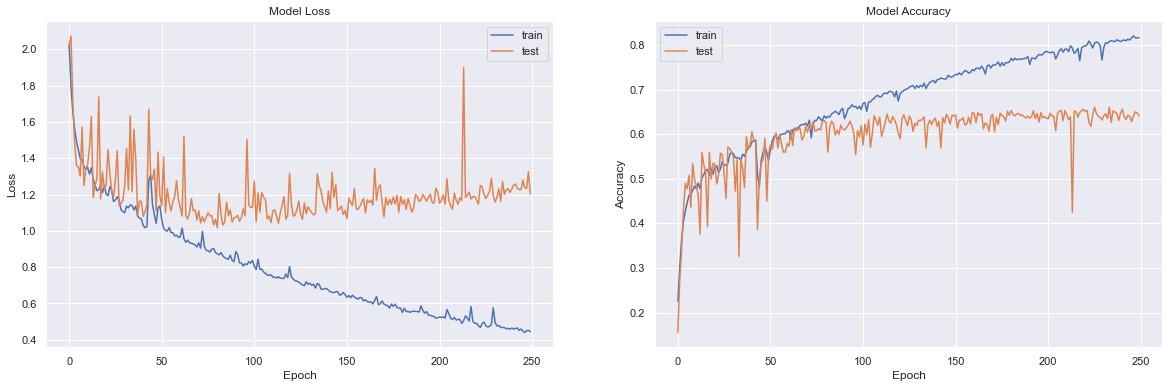

In [34]:
# SHOW HISTORY
plotHistory(history)

In [35]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaANN_ClassWeights_best.h5', custom_objects={'AAConv': AAConv})
model.evaluate(test_it)

29/29 [==============================] - 1s 41ms/step - loss: 1.0818 - sparse_categorical_accuracy: 0.6032


[1.0817657709121704, 0.6032320857048035]

29/29 [==============================] - 1s 38ms/step


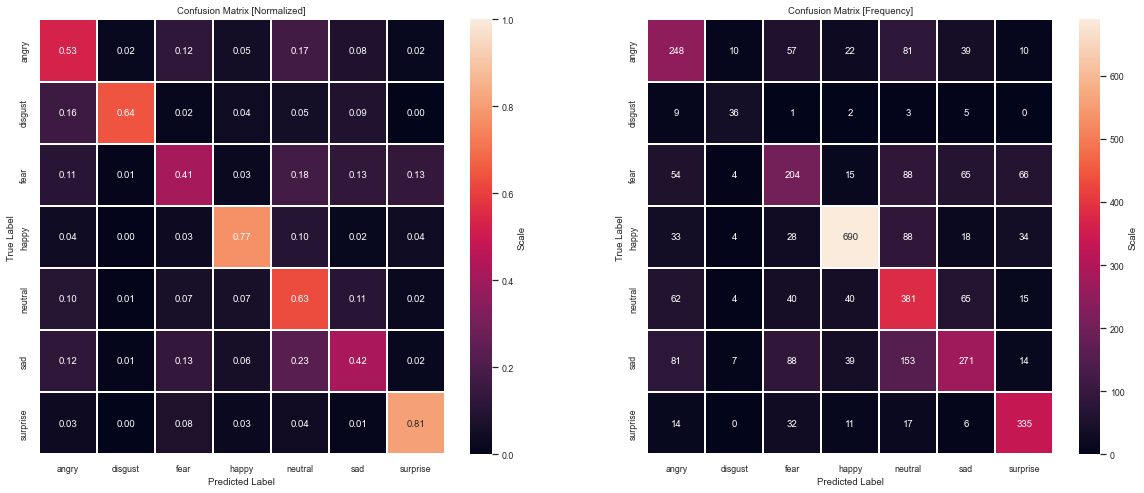

              precision    recall  f1-score   support

       angry       0.50      0.53      0.51       467
     disgust       0.55      0.64      0.60        56
        fear       0.45      0.41      0.43       496
       happy       0.84      0.77      0.81       895
     neutral       0.47      0.63      0.54       607
         sad       0.58      0.42      0.48       653
    surprise       0.71      0.81      0.75       415

    accuracy                           0.60      3589
   macro avg       0.59      0.60      0.59      3589
weighted avg       0.61      0.60      0.60      3589



In [36]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

### Simple CNN model + Convolutional Block Attention Module

> Woo, S., Park, J., Lee, J. Y., & Kweon, I. S. (2018). *CBAM: Convolutional block attention module*. In Proceedings of the European conference on computer vision (ECCV) (pp. 3-19). https://openaccess.thecvf.com/content_ECCV_2018/papers/Sanghyun_Woo_Convolutional_Block_Attention_ECCV_2018_paper.pdf

<center>
<img src="https://blog.paperspace.com/content/images/2020/05/Capture-1.PNG" alt="drawing" width="550"/>
    <br>
<img src="https://miro.medium.com/max/1400/0*WNEGJaXOZrNLtSv7" alt="drawing" width="550"/>
</center>

#### Without Class Weights

##### Metrics, loss, optimizer and checkpoints

In [37]:
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaCBAM_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [38]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaCBAM')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3 + CBAM
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name="CONV3"))
model.add(ChannelAttention(64, 16))
model.add(SpatialAttention(5))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaCBAM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 BATCHNORM2 (BatchNormalizat  (None, 23, 23, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 11, 11, 32)        0

##### Training

In [39]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 1.9611 - sparse_categorical_accuracy: 0.2870
Epoch 1: val_loss improved from inf to 1.96059, saving model to Models/FER2013\KazadaCBAM_best.h5
225/225 [==============================] - 22s 89ms/step - loss: 1.9611 - sparse_categorical_accuracy: 0.2870 - val_loss: 1.9606 - val_sparse_categorical_accuracy: 0.1649
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.6132 - sparse_categorical_accuracy: 0.3946
Epoch 2: val_loss improved from 1.96059 to 1.68530, saving model to Models/FER2013\KazadaCBAM_best.h5
225/225 [==============================] - 20s 89ms/step - loss: 1.6132 - sparse_categorical_accuracy: 0.3946 - val_loss: 1.6853 - val_sparse_categorical_accuracy: 0.3447
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.4617 - sparse_categorical_accuracy: 0.4454
Epoch 3: val_loss improved from 1.68530 to 1.45280, saving model to Models/FER2013\KazadaCBAM_best.h5
225/225 

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.0137 - sparse_categorical_accuracy: 0.6159
Epoch 24: val_loss improved from 1.07597 to 1.03637, saving model to Models/FER2013\KazadaCBAM_best.h5
225/225 [==============================] - 20s 87ms/step - loss: 1.0137 - sparse_categorical_accuracy: 0.6159 - val_loss: 1.0364 - val_sparse_categorical_accuracy: 0.6141
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.0118 - sparse_categorical_accuracy: 0.6174
Epoch 25: val_loss did not improve from 1.03637
225/225 [==============================] - 19s 86ms/step - loss: 1.0118 - sparse_categorical_accuracy: 0.6174 - val_loss: 1.0697 - val_sparse_categorical_accuracy: 0.6057
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.0149 - sparse_categorical_accuracy: 0.6188
Epoch 26: val_loss did not improve from 1.03637
225/225 [==============================] - 20s 87ms/step - loss: 1.0149 - sparse_categorical_accuracy: 0.618

Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 0.9038 - sparse_categorical_accuracy: 0.6595
Epoch 48: val_loss did not improve from 0.99087
225/225 [==============================] - 20s 89ms/step - loss: 0.9038 - sparse_categorical_accuracy: 0.6595 - val_loss: 1.0272 - val_sparse_categorical_accuracy: 0.6328
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 0.8889 - sparse_categorical_accuracy: 0.6643
Epoch 49: val_loss did not improve from 0.99087
225/225 [==============================] - 20s 89ms/step - loss: 0.8889 - sparse_categorical_accuracy: 0.6643 - val_loss: 1.1063 - val_sparse_categorical_accuracy: 0.5809
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 0.8796 - sparse_categorical_accuracy: 0.6666
Epoch 50: val_loss did not improve from 0.99087
225/225 [==============================] - 26s 117ms/step - loss: 0.8796 - sparse_categorical_accuracy: 0.6666 - val_loss: 1.1405 - val_sparse_categorical_accuracy

225/225 [==============================] - ETA: 0s - loss: 0.8213 - sparse_categorical_accuracy: 0.6910
Epoch 72: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 87ms/step - loss: 0.8213 - sparse_categorical_accuracy: 0.6910 - val_loss: 1.1681 - val_sparse_categorical_accuracy: 0.5979
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 0.8110 - sparse_categorical_accuracy: 0.6993
Epoch 73: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 88ms/step - loss: 0.8110 - sparse_categorical_accuracy: 0.6993 - val_loss: 1.0029 - val_sparse_categorical_accuracy: 0.6492
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 0.8111 - sparse_categorical_accuracy: 0.6958
Epoch 74: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 89ms/step - loss: 0.8111 - sparse_categorical_accuracy: 0.6958 - val_loss: 1.0701 - val_sparse_categorical_accuracy: 0.6233
Epoch

225/225 [==============================] - 21s 94ms/step - loss: 0.7502 - sparse_categorical_accuracy: 0.7187 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.6400
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.7580 - sparse_categorical_accuracy: 0.7156
Epoch 97: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 88ms/step - loss: 0.7580 - sparse_categorical_accuracy: 0.7156 - val_loss: 1.0084 - val_sparse_categorical_accuracy: 0.6525
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 0.7528 - sparse_categorical_accuracy: 0.7174
Epoch 98: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 89ms/step - loss: 0.7528 - sparse_categorical_accuracy: 0.7174 - val_loss: 1.0335 - val_sparse_categorical_accuracy: 0.6436
Epoch 99/250
225/225 [==============================] - ETA: 0s - loss: 0.7369 - sparse_categorical_accuracy: 0.7242
Epoch 99: val_loss did not improve from 

Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.7012 - sparse_categorical_accuracy: 0.7371
Epoch 121: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 87ms/step - loss: 0.7012 - sparse_categorical_accuracy: 0.7371 - val_loss: 1.1216 - val_sparse_categorical_accuracy: 0.6381
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.7029 - sparse_categorical_accuracy: 0.7414
Epoch 122: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 87ms/step - loss: 0.7029 - sparse_categorical_accuracy: 0.7414 - val_loss: 1.1669 - val_sparse_categorical_accuracy: 0.6294
Epoch 123/250
225/225 [==============================] - ETA: 0s - loss: 0.6932 - sparse_categorical_accuracy: 0.7408
Epoch 123: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 88ms/step - loss: 0.6932 - sparse_categorical_accuracy: 0.7408 - val_loss: 1.0398 - val_sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.6581 - sparse_categorical_accuracy: 0.7560
Epoch 145: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 90ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.7560 - val_loss: 1.0259 - val_sparse_categorical_accuracy: 0.6609
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.6476 - sparse_categorical_accuracy: 0.7573
Epoch 146: val_loss did not improve from 0.97830
225/225 [==============================] - 22s 97ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.7573 - val_loss: 1.1871 - val_sparse_categorical_accuracy: 0.6289
Epoch 147/250
225/225 [==============================] - ETA: 0s - loss: 0.6546 - sparse_categorical_accuracy: 0.7544
Epoch 147: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 88ms/step - loss: 0.6546 - sparse_categorical_accuracy: 0.7544 - val_loss: 1.0843 - val_sparse_categorical_accuracy: 0.6464


225/225 [==============================] - ETA: 0s - loss: 0.6253 - sparse_categorical_accuracy: 0.7669
Epoch 169: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 87ms/step - loss: 0.6253 - sparse_categorical_accuracy: 0.7669 - val_loss: 1.2141 - val_sparse_categorical_accuracy: 0.5940
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.6225 - sparse_categorical_accuracy: 0.7654
Epoch 170: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 88ms/step - loss: 0.6225 - sparse_categorical_accuracy: 0.7654 - val_loss: 1.0048 - val_sparse_categorical_accuracy: 0.6693
Epoch 171/250
225/225 [==============================] - ETA: 0s - loss: 0.6312 - sparse_categorical_accuracy: 0.7635
Epoch 171: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 89ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.7635 - val_loss: 1.1116 - val_sparse_categorical_accuracy: 0.6470


225/225 [==============================] - ETA: 0s - loss: 0.5824 - sparse_categorical_accuracy: 0.7814
Epoch 193: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 88ms/step - loss: 0.5824 - sparse_categorical_accuracy: 0.7814 - val_loss: 1.1144 - val_sparse_categorical_accuracy: 0.6470
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.5878 - sparse_categorical_accuracy: 0.7853
Epoch 194: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 88ms/step - loss: 0.5878 - sparse_categorical_accuracy: 0.7853 - val_loss: 1.0730 - val_sparse_categorical_accuracy: 0.6637
Epoch 195/250
225/225 [==============================] - ETA: 0s - loss: 0.5910 - sparse_categorical_accuracy: 0.7830
Epoch 195: val_loss did not improve from 0.97830
225/225 [==============================] - 19s 86ms/step - loss: 0.5910 - sparse_categorical_accuracy: 0.7830 - val_loss: 1.0823 - val_sparse_categorical_accuracy: 0.6654


225/225 [==============================] - ETA: 0s - loss: 0.5594 - sparse_categorical_accuracy: 0.7906
Epoch 217: val_loss did not improve from 0.97830
225/225 [==============================] - 19s 86ms/step - loss: 0.5594 - sparse_categorical_accuracy: 0.7906 - val_loss: 1.1755 - val_sparse_categorical_accuracy: 0.6620
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.5564 - sparse_categorical_accuracy: 0.7930
Epoch 218: val_loss did not improve from 0.97830
225/225 [==============================] - 19s 86ms/step - loss: 0.5564 - sparse_categorical_accuracy: 0.7930 - val_loss: 1.2156 - val_sparse_categorical_accuracy: 0.6314
Epoch 219/250
225/225 [==============================] - ETA: 0s - loss: 0.5583 - sparse_categorical_accuracy: 0.7933
Epoch 219: val_loss did not improve from 0.97830
225/225 [==============================] - 19s 86ms/step - loss: 0.5583 - sparse_categorical_accuracy: 0.7933 - val_loss: 1.1200 - val_sparse_categorical_accuracy: 0.6553


225/225 [==============================] - ETA: 0s - loss: 0.5527 - sparse_categorical_accuracy: 0.7961
Epoch 241: val_loss did not improve from 0.97830
225/225 [==============================] - 19s 87ms/step - loss: 0.5527 - sparse_categorical_accuracy: 0.7961 - val_loss: 1.2072 - val_sparse_categorical_accuracy: 0.6169
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.5545 - sparse_categorical_accuracy: 0.7951
Epoch 242: val_loss did not improve from 0.97830
225/225 [==============================] - 20s 87ms/step - loss: 0.5545 - sparse_categorical_accuracy: 0.7951 - val_loss: 1.1743 - val_sparse_categorical_accuracy: 0.6592
Epoch 243/250
225/225 [==============================] - ETA: 0s - loss: 0.5525 - sparse_categorical_accuracy: 0.7931
Epoch 243: val_loss did not improve from 0.97830
225/225 [==============================] - 19s 86ms/step - loss: 0.5525 - sparse_categorical_accuracy: 0.7931 - val_loss: 1.2202 - val_sparse_categorical_accuracy: 0.6489


##### History and performance

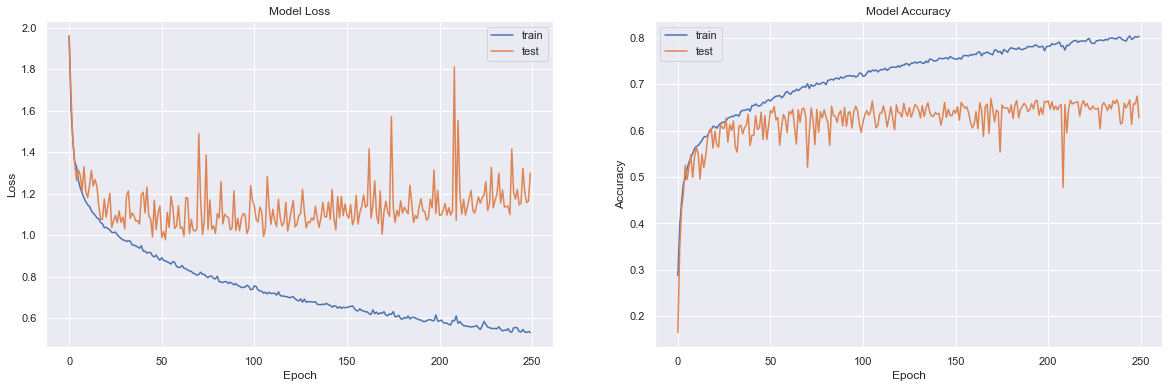

In [40]:
# SHOW HISTORY
plotHistory(history)

In [41]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaCBAM_best.h5', custom_objects={'ChannelAttention':ChannelAttention,'SpatialAttention':SpatialAttention})
model.evaluate(test_it)

29/29 [==============================] - 2s 63ms/step - loss: 1.0361 - sparse_categorical_accuracy: 0.6311


[1.0360649824142456, 0.6310949921607971]

29/29 [==============================] - 1s 37ms/step


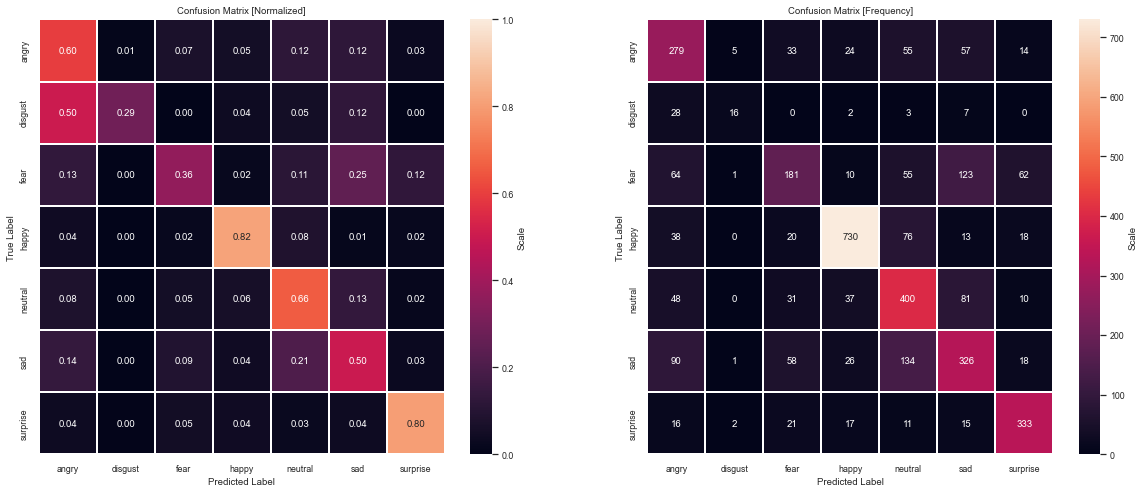

              precision    recall  f1-score   support

       angry       0.50      0.60      0.54       467
     disgust       0.64      0.29      0.40        56
        fear       0.53      0.36      0.43       496
       happy       0.86      0.82      0.84       895
     neutral       0.54      0.66      0.60       607
         sad       0.52      0.50      0.51       653
    surprise       0.73      0.80      0.77       415

    accuracy                           0.63      3589
   macro avg       0.62      0.57      0.58      3589
weighted avg       0.63      0.63      0.63      3589



In [42]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

#### With Class Weights

##### Metrics, loss, optimizer and checkpoints

In [43]:
WEIGHTS = getWeights(train_it)
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaCBAM_ClassWeights_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [44]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaCBAM')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3 + CBAM
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name="CONV3"))
model.add(ChannelAttention(64, 16))
model.add(SpatialAttention(5))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaCBAM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 BATCHNORM2 (BatchNormalizat  (None, 23, 23, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 11, 11, 32)        0

##### Training

In [45]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, class_weight=WEIGHTS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 2.1577 - sparse_categorical_accuracy: 0.2315
Epoch 1: val_loss improved from inf to 2.14720, saving model to Models/FER2013\KazadaCBAM_ClassWeights_best.h5
225/225 [==============================] - 22s 89ms/step - loss: 2.1577 - sparse_categorical_accuracy: 0.2315 - val_loss: 2.1472 - val_sparse_categorical_accuracy: 0.2444
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.7854 - sparse_categorical_accuracy: 0.3200
Epoch 2: val_loss improved from 2.14720 to 2.00982, saving model to Models/FER2013\KazadaCBAM_ClassWeights_best.h5
225/225 [==============================] - 20s 88ms/step - loss: 1.7854 - sparse_categorical_accuracy: 0.3200 - val_loss: 2.0098 - val_sparse_categorical_accuracy: 0.2109
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.6152 - sparse_categorical_accuracy: 0.3822
Epoch 3: val_loss improved from 2.00982 to 1.50928, saving model to Models/FER2013\K

225/225 [==============================] - ETA: 0s - loss: 1.0819 - sparse_categorical_accuracy: 0.5720
Epoch 24: val_loss did not improve from 1.15378
225/225 [==============================] - 20s 87ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.5720 - val_loss: 1.2589 - val_sparse_categorical_accuracy: 0.5378
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.1006 - sparse_categorical_accuracy: 0.5622
Epoch 25: val_loss did not improve from 1.15378
225/225 [==============================] - 22s 97ms/step - loss: 1.1006 - sparse_categorical_accuracy: 0.5622 - val_loss: 1.2652 - val_sparse_categorical_accuracy: 0.5375
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.0790 - sparse_categorical_accuracy: 0.5685
Epoch 26: val_loss did not improve from 1.15378
225/225 [==============================] - 20s 89ms/step - loss: 1.0790 - sparse_categorical_accuracy: 0.5685 - val_loss: 1.4004 - val_sparse_categorical_accuracy: 0.4759
Epoch

Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 0.9307 - sparse_categorical_accuracy: 0.6241
Epoch 48: val_loss did not improve from 1.11098
225/225 [==============================] - 20s 87ms/step - loss: 0.9307 - sparse_categorical_accuracy: 0.6241 - val_loss: 1.1155 - val_sparse_categorical_accuracy: 0.5795
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 0.9177 - sparse_categorical_accuracy: 0.6250
Epoch 49: val_loss did not improve from 1.11098
225/225 [==============================] - 20s 87ms/step - loss: 0.9177 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.2887 - val_sparse_categorical_accuracy: 0.5458
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 0.9072 - sparse_categorical_accuracy: 0.6304
Epoch 50: val_loss improved from 1.11098 to 1.05942, saving model to Models/FER2013\KazadaCBAM_ClassWeights_best.h5
225/225 [==============================] - 20s 88ms/step - loss: 0.9072 - sparse_categorical_ac

Epoch 72/250
225/225 [==============================] - ETA: 0s - loss: 0.8919 - sparse_categorical_accuracy: 0.6423
Epoch 72: val_loss did not improve from 1.04211
225/225 [==============================] - 20s 87ms/step - loss: 0.8919 - sparse_categorical_accuracy: 0.6423 - val_loss: 1.1930 - val_sparse_categorical_accuracy: 0.5949
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 0.8487 - sparse_categorical_accuracy: 0.6522
Epoch 73: val_loss did not improve from 1.04211
225/225 [==============================] - 20s 89ms/step - loss: 0.8487 - sparse_categorical_accuracy: 0.6522 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.5887
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 0.8564 - sparse_categorical_accuracy: 0.6510
Epoch 74: val_loss did not improve from 1.04211
225/225 [==============================] - 20s 88ms/step - loss: 0.8564 - sparse_categorical_accuracy: 0.6510 - val_loss: 1.3185 - val_sparse_categorical_accuracy:

225/225 [==============================] - 20s 88ms/step - loss: 0.7699 - sparse_categorical_accuracy: 0.6795 - val_loss: 1.1045 - val_sparse_categorical_accuracy: 0.6174
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.7850 - sparse_categorical_accuracy: 0.6767
Epoch 97: val_loss did not improve from 1.04211
225/225 [==============================] - 20s 87ms/step - loss: 0.7850 - sparse_categorical_accuracy: 0.6767 - val_loss: 1.4109 - val_sparse_categorical_accuracy: 0.5280
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 0.7749 - sparse_categorical_accuracy: 0.6788
Epoch 98: val_loss did not improve from 1.04211
225/225 [==============================] - 20s 89ms/step - loss: 0.7749 - sparse_categorical_accuracy: 0.6788 - val_loss: 1.0566 - val_sparse_categorical_accuracy: 0.6350
Epoch 99/250
225/225 [==============================] - ETA: 0s - loss: 0.7605 - sparse_categorical_accuracy: 0.6885
Epoch 99: val_loss did not improve from 

Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.7074 - sparse_categorical_accuracy: 0.7082
Epoch 121: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.7074 - sparse_categorical_accuracy: 0.7082 - val_loss: 1.0610 - val_sparse_categorical_accuracy: 0.6417
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.6887 - sparse_categorical_accuracy: 0.7142
Epoch 122: val_loss did not improve from 1.03101
225/225 [==============================] - 19s 86ms/step - loss: 0.6887 - sparse_categorical_accuracy: 0.7142 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.6266
Epoch 123/250
225/225 [==============================] - ETA: 0s - loss: 0.7061 - sparse_categorical_accuracy: 0.7070
Epoch 123: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.7061 - sparse_categorical_accuracy: 0.7070 - val_loss: 1.0861 - val_sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.6488 - sparse_categorical_accuracy: 0.7340
Epoch 145: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.6488 - sparse_categorical_accuracy: 0.7340 - val_loss: 1.2087 - val_sparse_categorical_accuracy: 0.6110
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.6556 - sparse_categorical_accuracy: 0.7267
Epoch 146: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.6556 - sparse_categorical_accuracy: 0.7267 - val_loss: 1.4369 - val_sparse_categorical_accuracy: 0.5506
Epoch 147/250
225/225 [==============================] - ETA: 0s - loss: 0.6589 - sparse_categorical_accuracy: 0.7279
Epoch 147: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.6589 - sparse_categorical_accuracy: 0.7279 - val_loss: 1.1183 - val_sparse_categorical_accuracy: 0.6386


225/225 [==============================] - ETA: 0s - loss: 0.6094 - sparse_categorical_accuracy: 0.7478
Epoch 169: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.6094 - sparse_categorical_accuracy: 0.7478 - val_loss: 1.0925 - val_sparse_categorical_accuracy: 0.6500
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.6188 - sparse_categorical_accuracy: 0.7475
Epoch 170: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.6188 - sparse_categorical_accuracy: 0.7475 - val_loss: 1.2944 - val_sparse_categorical_accuracy: 0.6121
Epoch 171/250
225/225 [==============================] - ETA: 0s - loss: 0.5964 - sparse_categorical_accuracy: 0.7527
Epoch 171: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.5964 - sparse_categorical_accuracy: 0.7527 - val_loss: 1.1469 - val_sparse_categorical_accuracy: 0.6411


225/225 [==============================] - ETA: 0s - loss: 0.5708 - sparse_categorical_accuracy: 0.7619
Epoch 193: val_loss did not improve from 1.03101
225/225 [==============================] - 19s 86ms/step - loss: 0.5708 - sparse_categorical_accuracy: 0.7619 - val_loss: 1.1681 - val_sparse_categorical_accuracy: 0.6389
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.5720 - sparse_categorical_accuracy: 0.7628
Epoch 194: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.5720 - sparse_categorical_accuracy: 0.7628 - val_loss: 1.1772 - val_sparse_categorical_accuracy: 0.6294
Epoch 195/250
225/225 [==============================] - ETA: 0s - loss: 0.6205 - sparse_categorical_accuracy: 0.7469
Epoch 195: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.6205 - sparse_categorical_accuracy: 0.7469 - val_loss: 1.1001 - val_sparse_categorical_accuracy: 0.6417


225/225 [==============================] - ETA: 0s - loss: 0.5394 - sparse_categorical_accuracy: 0.7783
Epoch 217: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.5394 - sparse_categorical_accuracy: 0.7783 - val_loss: 1.2848 - val_sparse_categorical_accuracy: 0.6199
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.5442 - sparse_categorical_accuracy: 0.7755
Epoch 218: val_loss did not improve from 1.03101
225/225 [==============================] - 19s 86ms/step - loss: 0.5442 - sparse_categorical_accuracy: 0.7755 - val_loss: 1.1728 - val_sparse_categorical_accuracy: 0.6422
Epoch 219/250
225/225 [==============================] - ETA: 0s - loss: 0.5392 - sparse_categorical_accuracy: 0.7762
Epoch 219: val_loss did not improve from 1.03101
225/225 [==============================] - 19s 86ms/step - loss: 0.5392 - sparse_categorical_accuracy: 0.7762 - val_loss: 1.2405 - val_sparse_categorical_accuracy: 0.6372


225/225 [==============================] - ETA: 0s - loss: 0.5232 - sparse_categorical_accuracy: 0.7805
Epoch 241: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.5232 - sparse_categorical_accuracy: 0.7805 - val_loss: 1.1899 - val_sparse_categorical_accuracy: 0.6272
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.5160 - sparse_categorical_accuracy: 0.7840
Epoch 242: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.5160 - sparse_categorical_accuracy: 0.7840 - val_loss: 1.3090 - val_sparse_categorical_accuracy: 0.6205
Epoch 243/250
225/225 [==============================] - ETA: 0s - loss: 0.5266 - sparse_categorical_accuracy: 0.7821
Epoch 243: val_loss did not improve from 1.03101
225/225 [==============================] - 20s 87ms/step - loss: 0.5266 - sparse_categorical_accuracy: 0.7821 - val_loss: 1.2882 - val_sparse_categorical_accuracy: 0.6266


##### History and performance

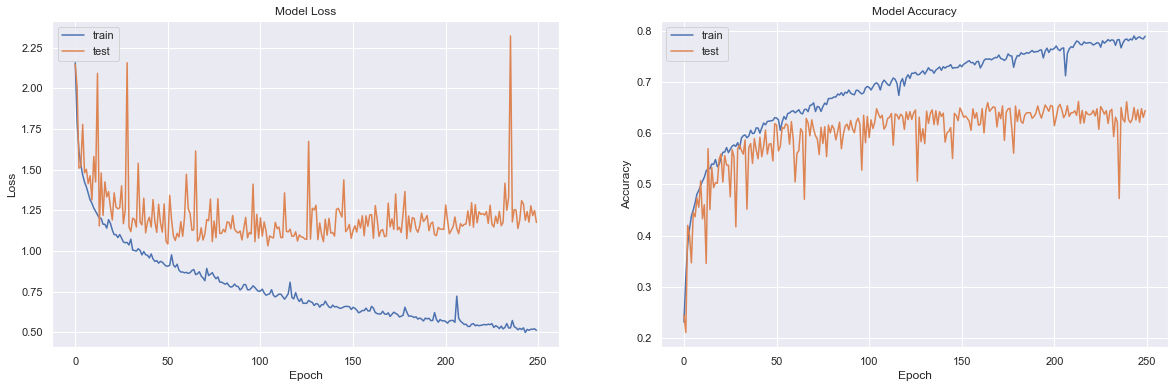

In [46]:
# SHOW HISTORY
plotHistory(history)

In [47]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaCBAM_ClassWeights_best.h5', custom_objects={'ChannelAttention':ChannelAttention,'SpatialAttention':SpatialAttention})
model.evaluate(test_it)

29/29 [==============================] - 2s 42ms/step - loss: 1.0945 - sparse_categorical_accuracy: 0.6361


[1.0944925546646118, 0.6361103653907776]

29/29 [==============================] - 1s 38ms/step


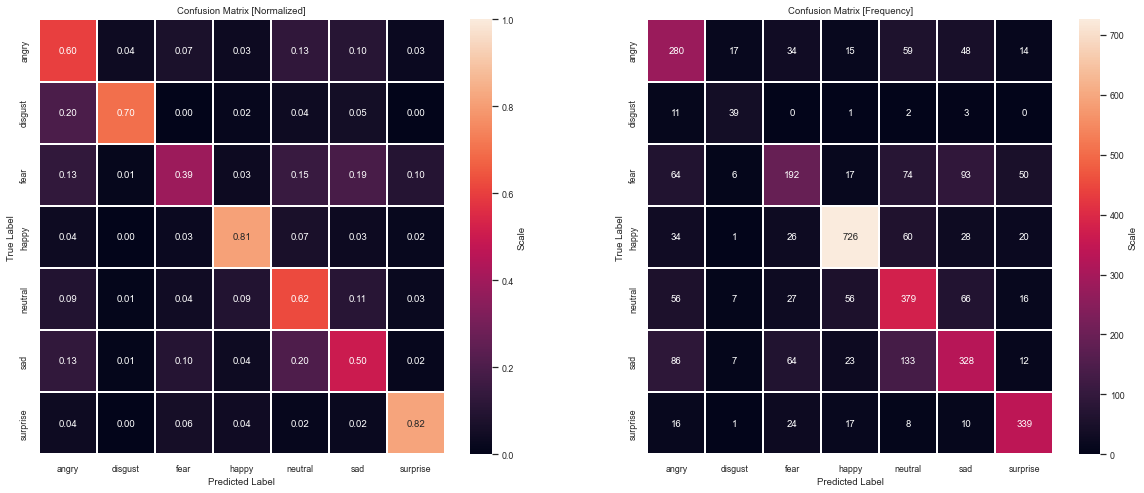

              precision    recall  f1-score   support

       angry       0.51      0.60      0.55       467
     disgust       0.50      0.70      0.58        56
        fear       0.52      0.39      0.44       496
       happy       0.85      0.81      0.83       895
     neutral       0.53      0.62      0.57       607
         sad       0.57      0.50      0.53       653
    surprise       0.75      0.82      0.78       415

    accuracy                           0.64      3589
   macro avg       0.61      0.63      0.61      3589
weighted avg       0.64      0.64      0.63      3589



In [48]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

### Gradcam++

Grad-CAM works by (1) finding the final convolutional layer in the network and then (2) examining the gradient information flowing into that layer.

The output of Grad-CAM is a heatmap visualization for a given class label (either the top, predicted label or an arbitrary label we select for debugging). We can use this heatmap to visually verify where in the image the CNN is looking.

> Chattopadhay, A., Sarkar, A., Howlader, P., & Balasubramanian, V. N. (2018, March). *Grad-cam++: Generalized gradient-based visual explanations for deep convolutional networks.* In 2018 IEEE winter conference on applications of computer vision (WACV) (pp. 839-847). IEEE. https://arxiv.org/pdf/1710.11063.pdf

In [49]:
N_IMAGES = 20

In [50]:
#define a model modifier
replace2linear = ReplaceToLinear()

In [51]:
#get images from iterator
X_test, y_test = next(test_it)
y_test = y_test.astype('int')
print(X_test.shape, y_test.shape)

(128, 48, 48, 1) (128,)


In [52]:
class_names = test_it.class_indices
class_names_dict = dict(zip(class_names.values(), class_names.keys()))
class_names_dict

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [53]:
# Load images and Convert them to a Numpy array
images = np.asarray(X_test[:N_IMAGES])

In [54]:
modelCNN = load_model('Models/'+DATASET+'/KazadaCNN_best.h5')
modelANN = load_model('Models/'+DATASET+'/KazadaANN_best.h5', custom_objects={'AAConv': AAConv})
modelCBAM = load_model('Models/'+DATASET+'/KazadaCBAM_best.h5', custom_objects={'ChannelAttention':ChannelAttention,'SpatialAttention':SpatialAttention})

In [55]:
### CNN CAM
y_pred_CNN = modelCNN.predict(X_test)
y_pred_CNN = np.argmax(y_pred_CNN, axis=1)
titles = makeTitle(y_pred_CNN[:N_IMAGES], y_test[:N_IMAGES], class_names_dict)
gradcam_CNN = GradcamPlusPlus(modelCNN, model_modifier=replace2linear, clone=True)
score_CNN = CategoricalScore(list(y_pred_CNN[:N_IMAGES]))
cam_CNN = gradcam_CNN(score_CNN, images, penultimate_layer=-1)

### ANN CAM
y_pred_ANN = modelANN.predict(X_test)
y_pred_ANN = np.argmax(y_pred_ANN, axis=1)
titles = makeTitle(y_pred_ANN[:N_IMAGES], y_test[:N_IMAGES], class_names_dict)
gradcam_ANN = GradcamPlusPlus(modelANN, model_modifier=replace2linear, clone=True)
score_ANN = CategoricalScore(list(y_pred_ANN[:N_IMAGES]))
cam_ANN = gradcam_ANN(score_ANN, images, penultimate_layer=-1)

### CBAM CAM
y_pred_CBAM = modelCBAM.predict(X_test)
y_pred_CBAM = np.argmax(y_pred_CBAM, axis=1)
titles = makeTitle(y_pred_CBAM[:N_IMAGES], y_test[:N_IMAGES], class_names_dict)
gradcam_CBAM = GradcamPlusPlus(modelCBAM, model_modifier=replace2linear, clone=True)
score_CBAM = CategoricalScore(list(y_pred_CBAM[:N_IMAGES]))
cam_CBAM = gradcam_CBAM(score_CBAM, images, penultimate_layer=-1)

4/4 [==============================] - 0s 4ms/step


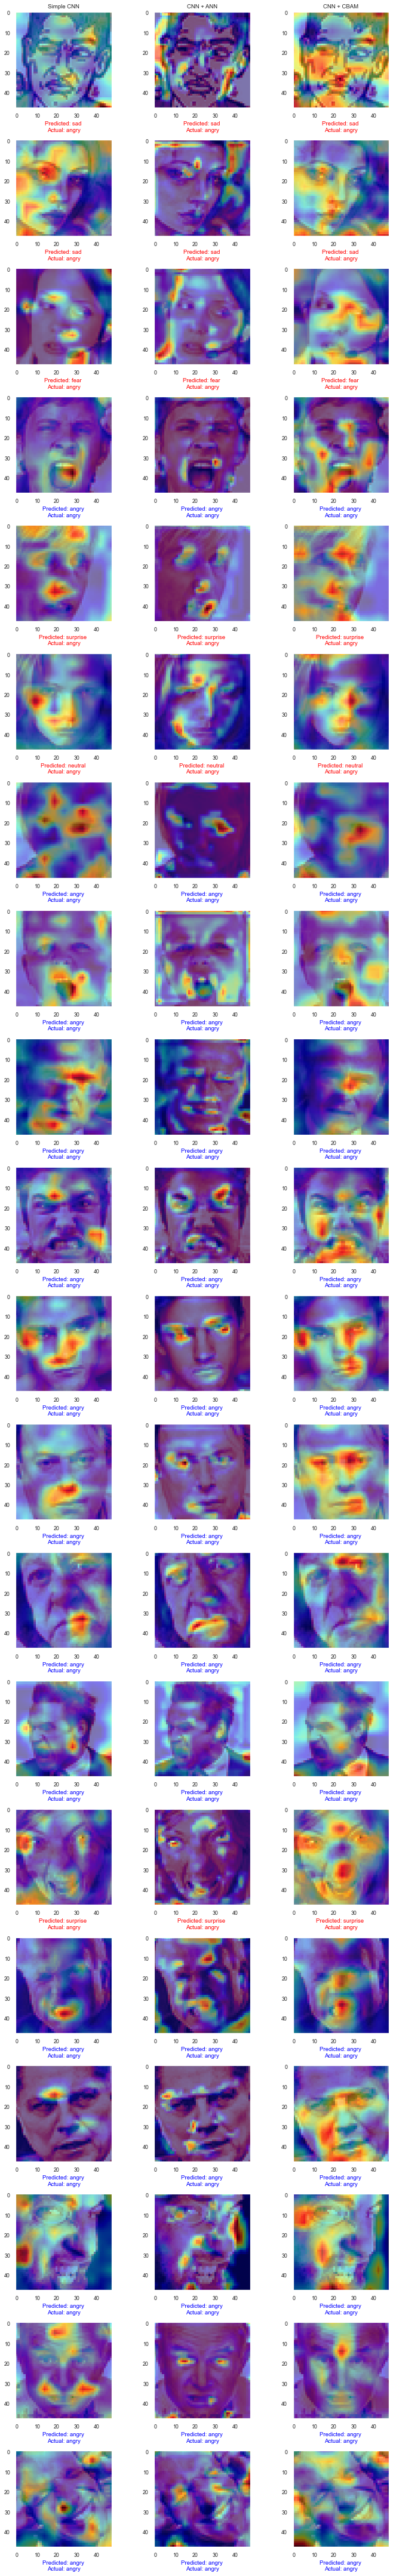

In [56]:
# Render
f, axes = plt.subplots(nrows=N_IMAGES, ncols=3, figsize=(10, 3*N_IMAGES))
axes[0][0].set_title('Simple CNN')
axes[0][1].set_title('CNN + ANN')
axes[0][2].set_title('CNN + CBAM')
for i, title in enumerate(titles):
    #1st model
    heatmap = np.uint8(cm.jet(cam_CNN[i])[..., :3] * 255)
    axes[i][0].set_xlabel(title[0], color=('blue' if title[1] == True else 'red'))
    axes[i][0].imshow(images[i])
    axes[i][0].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[i][0].axis('on')
    axes[i][0].grid(b=None)
    #2nd model
    heatmap_ANN = np.uint8(cm.jet(cam_ANN[i])[..., :3] * 255)
    axes[i][1].set_xlabel(title[0], color=('blue' if title[1] == True else 'red'))
    axes[i][1].imshow(images[i])
    axes[i][1].imshow(heatmap_ANN, cmap='jet', alpha=0.5)
    axes[i][1].axis('on')
    axes[i][1].grid(b=None)
    #3rd model
    heatmap_CBAM = np.uint8(cm.jet(cam_CBAM[i])[..., :3] * 255)
    axes[i][2].set_xlabel(title[0], color=('blue' if title[1] == True else 'red'))
    axes[i][2].imshow(images[i])
    axes[i][2].imshow(heatmap_CBAM, cmap='jet', alpha=0.5)
    axes[i][2].axis('on')
    axes[i][2].grid(b=None)

plt.tight_layout()
plt.show()

## Considerations and next steps...

### (1) Oversampling the minority classes with GAN
<br>
<center>
    <img src="https://i.imgur.com/L9LUQ9o.png" alt="GAN augmentation" width="600"/>
</center>

> Porcu, S., Floris, A., & Atzori, L. (2020). *Evaluation of data augmentation techniques for facial expression recognition systems.* Electronics, 9(11), 1892. https://www.mdpi.com/2079-9292/9/11/1892/pdf

### (2) Use DropBlocks [ < overfitting; > accuracy ]
<br>
<center>
    <img src="https://miro.medium.com/max/1400/0*73TbHT81NVdUcOST" alt="DropBlocks" width="600"/>
</center>

> Ghiasi, G., Lin, T. Y., & Le, Q. V. (2018). *Dropblock: A regularization method for convolutional networks.* Advances in neural information processing systems, 31. https://proceedings.neurips.cc/paper/2018/file/7edcfb2d8f6a659ef4cd1e6c9b6d7079-Paper.pdf

### (3) Add more Attention layers

## (2) Adding DropBlocks

### Simple CNN + DropBlocks

##### Metrics, loss, optimizer and checkpoints

In [57]:
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaDropBlock_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [58]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaDropBlocks')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(DropBlock2D(keep_prob=0.95,block_size=5, name='DROPBLOCK1'))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(DropBlock2D(keep_prob=0.85,block_size=4, name='DROPBLOCK2'))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name="CONV3"))
model.add(DropBlock2D(keep_prob=0.75,block_size=5, name='DROPBLOCK3'))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaDropBlocks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 DROPBLOCK1 (DropBlock2D)    (None, 48, 48, 32)        0         
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 DROPBLOCK2 (DropBlock2D)    (None, 23, 23, 32)        0         
                                                  

##### Training

In [59]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 1.9892 - sparse_categorical_accuracy: 0.2773
Epoch 1: val_loss improved from inf to 1.96199, saving model to Models/FER2013\KazadaDropBlock_best.h5
225/225 [==============================] - 23s 89ms/step - loss: 1.9892 - sparse_categorical_accuracy: 0.2773 - val_loss: 1.9620 - val_sparse_categorical_accuracy: 0.1672
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.6467 - sparse_categorical_accuracy: 0.3709
Epoch 2: val_loss improved from 1.96199 to 1.70506, saving model to Models/FER2013\KazadaDropBlock_best.h5
225/225 [==============================] - 20s 89ms/step - loss: 1.6467 - sparse_categorical_accuracy: 0.3709 - val_loss: 1.7051 - val_sparse_categorical_accuracy: 0.3628
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.4977 - sparse_categorical_accuracy: 0.4228
Epoch 3: val_loss improved from 1.70506 to 1.43522, saving model to Models/FER2013\KazadaDropBlock_b

225/225 [==============================] - ETA: 0s - loss: 1.1492 - sparse_categorical_accuracy: 0.5648
Epoch 23: val_loss did not improve from 1.05167
225/225 [==============================] - 20s 87ms/step - loss: 1.1492 - sparse_categorical_accuracy: 0.5648 - val_loss: 1.0749 - val_sparse_categorical_accuracy: 0.5851
Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.1348 - sparse_categorical_accuracy: 0.5701
Epoch 24: val_loss did not improve from 1.05167
225/225 [==============================] - 20s 87ms/step - loss: 1.1348 - sparse_categorical_accuracy: 0.5701 - val_loss: 1.0717 - val_sparse_categorical_accuracy: 0.6046
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.1295 - sparse_categorical_accuracy: 0.5682
Epoch 25: val_loss improved from 1.05167 to 1.03306, saving model to Models/FER2013\KazadaDropBlock_best.h5
225/225 [==============================] - 20s 87ms/step - loss: 1.1295 - sparse_categorical_accuracy: 0.5682 - val_

Epoch 47/250
225/225 [==============================] - ETA: 0s - loss: 1.0546 - sparse_categorical_accuracy: 0.6016
Epoch 47: val_loss improved from 0.99247 to 0.97846, saving model to Models/FER2013\KazadaDropBlock_best.h5
225/225 [==============================] - 20s 87ms/step - loss: 1.0546 - sparse_categorical_accuracy: 0.6016 - val_loss: 0.9785 - val_sparse_categorical_accuracy: 0.6361
Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 1.0403 - sparse_categorical_accuracy: 0.6059
Epoch 48: val_loss did not improve from 0.97846
225/225 [==============================] - 20s 87ms/step - loss: 1.0403 - sparse_categorical_accuracy: 0.6059 - val_loss: 1.0206 - val_sparse_categorical_accuracy: 0.6169
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 1.0375 - sparse_categorical_accuracy: 0.6086
Epoch 49: val_loss improved from 0.97846 to 0.97560, saving model to Models/FER2013\KazadaDropBlock_best.h5
225/225 [==============================] - 

225/225 [==============================] - 20s 87ms/step - loss: 0.9975 - sparse_categorical_accuracy: 0.6233 - val_loss: 0.9542 - val_sparse_categorical_accuracy: 0.6470
Epoch 71/250
225/225 [==============================] - ETA: 0s - loss: 0.9866 - sparse_categorical_accuracy: 0.6234
Epoch 71: val_loss did not improve from 0.95424
225/225 [==============================] - 20s 87ms/step - loss: 0.9866 - sparse_categorical_accuracy: 0.6234 - val_loss: 0.9785 - val_sparse_categorical_accuracy: 0.6450
Epoch 72/250
225/225 [==============================] - ETA: 0s - loss: 0.9876 - sparse_categorical_accuracy: 0.6267
Epoch 72: val_loss did not improve from 0.95424
225/225 [==============================] - 20s 87ms/step - loss: 0.9876 - sparse_categorical_accuracy: 0.6267 - val_loss: 1.1536 - val_sparse_categorical_accuracy: 0.5779
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 0.9857 - sparse_categorical_accuracy: 0.6282
Epoch 73: val_loss improved from 0.95424

Epoch 95/250
225/225 [==============================] - ETA: 0s - loss: 0.9506 - sparse_categorical_accuracy: 0.6406
Epoch 95: val_loss did not improve from 0.94877
225/225 [==============================] - 19s 86ms/step - loss: 0.9506 - sparse_categorical_accuracy: 0.6406 - val_loss: 0.9708 - val_sparse_categorical_accuracy: 0.6442
Epoch 96/250
225/225 [==============================] - ETA: 0s - loss: 0.9431 - sparse_categorical_accuracy: 0.6460
Epoch 96: val_loss did not improve from 0.94877
225/225 [==============================] - 20s 87ms/step - loss: 0.9431 - sparse_categorical_accuracy: 0.6460 - val_loss: 0.9581 - val_sparse_categorical_accuracy: 0.6495
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.9478 - sparse_categorical_accuracy: 0.6429
Epoch 97: val_loss improved from 0.94877 to 0.94614, saving model to Models/FER2013\KazadaDropBlock_best.h5
225/225 [==============================] - 20s 87ms/step - loss: 0.9478 - sparse_categorical_accuracy: 

Epoch 119/250
225/225 [==============================] - ETA: 0s - loss: 0.9096 - sparse_categorical_accuracy: 0.6587
Epoch 119: val_loss did not improve from 0.92606
225/225 [==============================] - 20s 87ms/step - loss: 0.9096 - sparse_categorical_accuracy: 0.6587 - val_loss: 0.9373 - val_sparse_categorical_accuracy: 0.6604
Epoch 120/250
225/225 [==============================] - ETA: 0s - loss: 0.9092 - sparse_categorical_accuracy: 0.6600
Epoch 120: val_loss did not improve from 0.92606
225/225 [==============================] - 20s 87ms/step - loss: 0.9092 - sparse_categorical_accuracy: 0.6600 - val_loss: 0.9631 - val_sparse_categorical_accuracy: 0.6461
Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.9116 - sparse_categorical_accuracy: 0.6555
Epoch 121: val_loss did not improve from 0.92606
225/225 [==============================] - 20s 87ms/step - loss: 0.9116 - sparse_categorical_accuracy: 0.6555 - val_loss: 0.9418 - val_sparse_categorical_acc

Epoch 143/250
225/225 [==============================] - ETA: 0s - loss: 0.8829 - sparse_categorical_accuracy: 0.6690
Epoch 143: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 89ms/step - loss: 0.8829 - sparse_categorical_accuracy: 0.6690 - val_loss: 0.9326 - val_sparse_categorical_accuracy: 0.6701
Epoch 144/250
225/225 [==============================] - ETA: 0s - loss: 0.8835 - sparse_categorical_accuracy: 0.6695
Epoch 144: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 89ms/step - loss: 0.8835 - sparse_categorical_accuracy: 0.6695 - val_loss: 0.9702 - val_sparse_categorical_accuracy: 0.6475
Epoch 145/250
225/225 [==============================] - ETA: 0s - loss: 0.8838 - sparse_categorical_accuracy: 0.6684
Epoch 145: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 87ms/step - loss: 0.8838 - sparse_categorical_accuracy: 0.6684 - val_loss: 0.9539 - val_sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.8591 - sparse_categorical_accuracy: 0.6756
Epoch 167: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 87ms/step - loss: 0.8591 - sparse_categorical_accuracy: 0.6756 - val_loss: 0.9239 - val_sparse_categorical_accuracy: 0.6690
Epoch 168/250
225/225 [==============================] - ETA: 0s - loss: 0.8530 - sparse_categorical_accuracy: 0.6810
Epoch 168: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 87ms/step - loss: 0.8530 - sparse_categorical_accuracy: 0.6810 - val_loss: 0.9491 - val_sparse_categorical_accuracy: 0.6617
Epoch 169/250
225/225 [==============================] - ETA: 0s - loss: 0.8517 - sparse_categorical_accuracy: 0.6798
Epoch 169: val_loss did not improve from 0.90982
225/225 [==============================] - 19s 86ms/step - loss: 0.8517 - sparse_categorical_accuracy: 0.6798 - val_loss: 0.9749 - val_sparse_categorical_accuracy: 0.6534


225/225 [==============================] - ETA: 0s - loss: 0.8330 - sparse_categorical_accuracy: 0.6862
Epoch 191: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 87ms/step - loss: 0.8330 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.9858 - val_sparse_categorical_accuracy: 0.6484
Epoch 192/250
225/225 [==============================] - ETA: 0s - loss: 0.8276 - sparse_categorical_accuracy: 0.6878
Epoch 192: val_loss did not improve from 0.90982
225/225 [==============================] - 19s 86ms/step - loss: 0.8276 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.9934 - val_sparse_categorical_accuracy: 0.6573
Epoch 193/250
225/225 [==============================] - ETA: 0s - loss: 0.8313 - sparse_categorical_accuracy: 0.6905
Epoch 193: val_loss did not improve from 0.90982
225/225 [==============================] - 19s 86ms/step - loss: 0.8313 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.9470 - val_sparse_categorical_accuracy: 0.6590


225/225 [==============================] - ETA: 0s - loss: 0.8036 - sparse_categorical_accuracy: 0.7013
Epoch 215: val_loss did not improve from 0.90982
225/225 [==============================] - 19s 86ms/step - loss: 0.8036 - sparse_categorical_accuracy: 0.7013 - val_loss: 0.9849 - val_sparse_categorical_accuracy: 0.6565
Epoch 216/250
225/225 [==============================] - ETA: 0s - loss: 0.8118 - sparse_categorical_accuracy: 0.6972
Epoch 216: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 88ms/step - loss: 0.8118 - sparse_categorical_accuracy: 0.6972 - val_loss: 0.9360 - val_sparse_categorical_accuracy: 0.6676
Epoch 217/250
225/225 [==============================] - ETA: 0s - loss: 0.8129 - sparse_categorical_accuracy: 0.6968
Epoch 217: val_loss did not improve from 0.90982
225/225 [==============================] - 19s 86ms/step - loss: 0.8129 - sparse_categorical_accuracy: 0.6968 - val_loss: 0.9199 - val_sparse_categorical_accuracy: 0.6695


225/225 [==============================] - ETA: 0s - loss: 0.7922 - sparse_categorical_accuracy: 0.7034
Epoch 239: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 87ms/step - loss: 0.7922 - sparse_categorical_accuracy: 0.7034 - val_loss: 0.9776 - val_sparse_categorical_accuracy: 0.6467
Epoch 240/250
225/225 [==============================] - ETA: 0s - loss: 0.7978 - sparse_categorical_accuracy: 0.7026
Epoch 240: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 87ms/step - loss: 0.7978 - sparse_categorical_accuracy: 0.7026 - val_loss: 0.9855 - val_sparse_categorical_accuracy: 0.6679
Epoch 241/250
225/225 [==============================] - ETA: 0s - loss: 0.7885 - sparse_categorical_accuracy: 0.7064
Epoch 241: val_loss did not improve from 0.90982
225/225 [==============================] - 20s 87ms/step - loss: 0.7885 - sparse_categorical_accuracy: 0.7064 - val_loss: 0.9877 - val_sparse_categorical_accuracy: 0.6484


##### History and performance

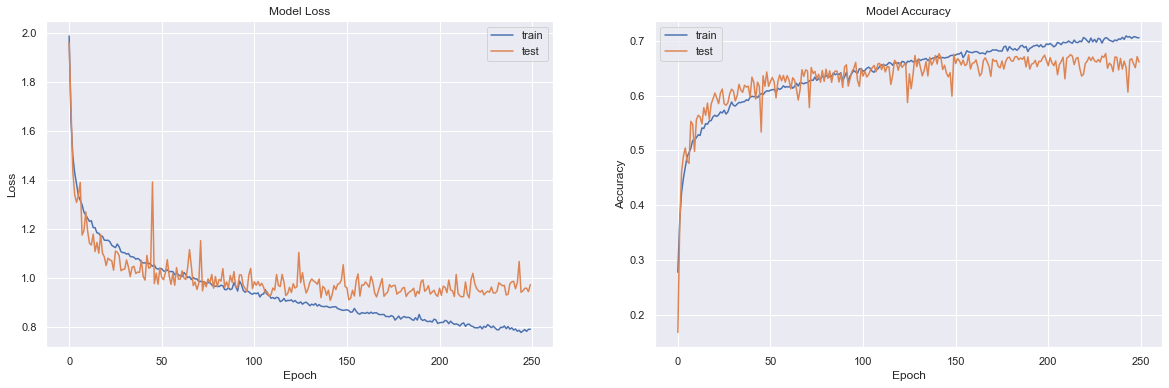

In [60]:
# SHOW HISTORY
plotHistory(history)

In [61]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaDropBlock_best.h5', custom_objects={'DropBlock2D':DropBlock2D})
model.evaluate(test_it)

29/29 [==============================] - 2s 42ms/step - loss: 0.9716 - sparse_categorical_accuracy: 0.6512


[0.9715868234634399, 0.6511563062667847]

29/29 [==============================] - 1s 38ms/step


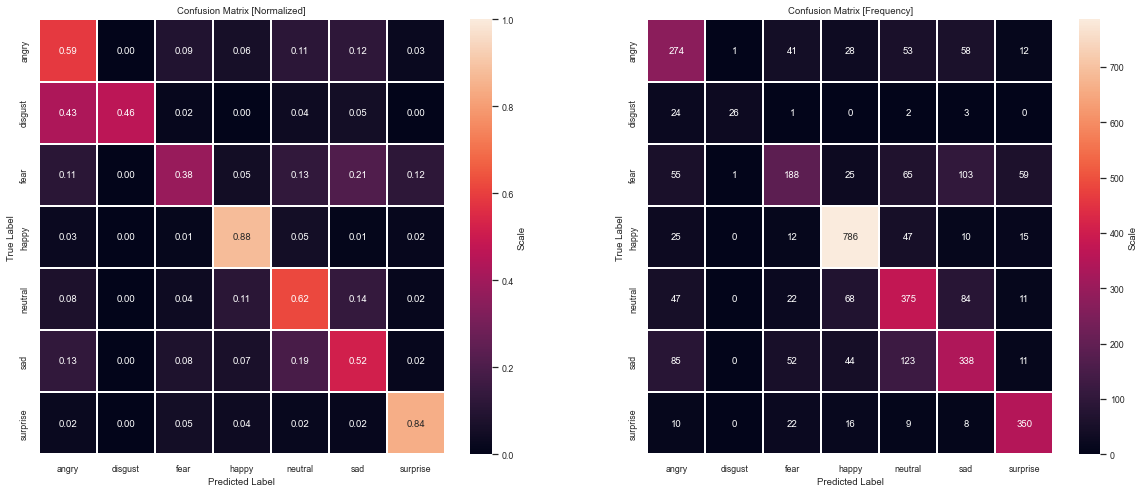

              precision    recall  f1-score   support

       angry       0.53      0.59      0.56       467
     disgust       0.93      0.46      0.62        56
        fear       0.56      0.38      0.45       496
       happy       0.81      0.88      0.84       895
     neutral       0.56      0.62      0.59       607
         sad       0.56      0.52      0.54       653
    surprise       0.76      0.84      0.80       415

    accuracy                           0.65      3589
   macro avg       0.67      0.61      0.63      3589
weighted avg       0.65      0.65      0.64      3589



In [62]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

### Simple CNN model + DropBlocks + Attention Augmented Convolutional Networks

##### Metrics, loss, optimizer and checkpoints

In [63]:
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaDB_ANN_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [64]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaDB_ANN')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(DropBlock2D(keep_prob=0.95,block_size=5, name='DROPBLOCK1'))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(DropBlock2D(keep_prob=0.85,block_size=5, name='DROPBLOCK2'))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3 (ATTENTION AUGMENTED VARIANT)
model.add(AAConv(channels_out=64, kernel_size=(5,5), activation='relu',num_heads=4 , depth_k=4, depth_v=4, name="CONV3AA"))
model.add(DropBlock2D(keep_prob=0.75,block_size=5, name='DROPBLOCK3'))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaDB_ANN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 DROPBLOCK1 (DropBlock2D)    (None, 48, 48, 32)        0         
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 DROPBLOCK2 (DropBlock2D)    (None, 23, 23, 32)        0         
                                                      

##### Training

In [65]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 1.9190 - sparse_categorical_accuracy: 0.2718
Epoch 1: val_loss improved from inf to 1.84433, saving model to Models/FER2013\KazadaDB_ANN_best.h5
225/225 [==============================] - 23s 90ms/step - loss: 1.9190 - sparse_categorical_accuracy: 0.2718 - val_loss: 1.8443 - val_sparse_categorical_accuracy: 0.2513
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.6799 - sparse_categorical_accuracy: 0.3505
Epoch 2: val_loss improved from 1.84433 to 1.70065, saving model to Models/FER2013\KazadaDB_ANN_best.h5
225/225 [==============================] - 20s 90ms/step - loss: 1.6799 - sparse_categorical_accuracy: 0.3505 - val_loss: 1.7007 - val_sparse_categorical_accuracy: 0.3174
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.5571 - sparse_categorical_accuracy: 0.3964
Epoch 3: val_loss improved from 1.70065 to 1.63473, saving model to Models/FER2013\KazadaDB_ANN_best.h5
22

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.2108 - sparse_categorical_accuracy: 0.5344
Epoch 24: val_loss did not improve from 1.14987
225/225 [==============================] - 20s 88ms/step - loss: 1.2108 - sparse_categorical_accuracy: 0.5344 - val_loss: 1.2118 - val_sparse_categorical_accuracy: 0.5581
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.2031 - sparse_categorical_accuracy: 0.5416
Epoch 25: val_loss improved from 1.14987 to 1.14197, saving model to Models/FER2013\KazadaDB_ANN_best.h5
225/225 [==============================] - 20s 88ms/step - loss: 1.2031 - sparse_categorical_accuracy: 0.5416 - val_loss: 1.1420 - val_sparse_categorical_accuracy: 0.5709
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.1883 - sparse_categorical_accuracy: 0.5477
Epoch 26: val_loss improved from 1.14197 to 1.09816, saving model to Models/FER2013\KazadaDB_ANN_best.h5
225/225 [==============================] - 20s 89

Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 1.1019 - sparse_categorical_accuracy: 0.5826
Epoch 48: val_loss did not improve from 1.05862
225/225 [==============================] - 20s 88ms/step - loss: 1.1019 - sparse_categorical_accuracy: 0.5826 - val_loss: 1.3412 - val_sparse_categorical_accuracy: 0.5787
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 1.0882 - sparse_categorical_accuracy: 0.5874
Epoch 49: val_loss did not improve from 1.05862
225/225 [==============================] - 20s 90ms/step - loss: 1.0882 - sparse_categorical_accuracy: 0.5874 - val_loss: 1.1959 - val_sparse_categorical_accuracy: 0.5993
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 1.1099 - sparse_categorical_accuracy: 0.5786
Epoch 50: val_loss improved from 1.05862 to 1.02713, saving model to Models/FER2013\KazadaDB_ANN_best.h5
225/225 [==============================] - 20s 90ms/step - loss: 1.1099 - sparse_categorical_accuracy: 0.5

Epoch 72/250
225/225 [==============================] - ETA: 0s - loss: 1.0408 - sparse_categorical_accuracy: 0.6051
Epoch 72: val_loss did not improve from 1.01790
225/225 [==============================] - 20s 88ms/step - loss: 1.0408 - sparse_categorical_accuracy: 0.6051 - val_loss: 1.1250 - val_sparse_categorical_accuracy: 0.6160
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 1.0434 - sparse_categorical_accuracy: 0.6049
Epoch 73: val_loss did not improve from 1.01790
225/225 [==============================] - 20s 88ms/step - loss: 1.0434 - sparse_categorical_accuracy: 0.6049 - val_loss: 1.0475 - val_sparse_categorical_accuracy: 0.6105
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 1.0261 - sparse_categorical_accuracy: 0.6136
Epoch 74: val_loss improved from 1.01790 to 1.01337, saving model to Models/FER2013\KazadaDB_ANN_best.h5
225/225 [==============================] - 20s 89ms/step - loss: 1.0261 - sparse_categorical_accuracy: 0.6

Epoch 96/250
225/225 [==============================] - ETA: 0s - loss: 0.9765 - sparse_categorical_accuracy: 0.6349
Epoch 96: val_loss did not improve from 0.99896
225/225 [==============================] - 20s 88ms/step - loss: 0.9765 - sparse_categorical_accuracy: 0.6349 - val_loss: 1.0640 - val_sparse_categorical_accuracy: 0.6291
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.9762 - sparse_categorical_accuracy: 0.6292
Epoch 97: val_loss did not improve from 0.99896
225/225 [==============================] - 20s 88ms/step - loss: 0.9762 - sparse_categorical_accuracy: 0.6292 - val_loss: 1.0795 - val_sparse_categorical_accuracy: 0.6244
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 0.9805 - sparse_categorical_accuracy: 0.6300
Epoch 98: val_loss did not improve from 0.99896
225/225 [==============================] - 20s 88ms/step - loss: 0.9805 - sparse_categorical_accuracy: 0.6300 - val_loss: 1.0698 - val_sparse_categorical_accuracy:

225/225 [==============================] - ETA: 0s - loss: 0.9449 - sparse_categorical_accuracy: 0.6446
Epoch 120: val_loss did not improve from 0.99896
225/225 [==============================] - 20s 88ms/step - loss: 0.9449 - sparse_categorical_accuracy: 0.6446 - val_loss: 1.0027 - val_sparse_categorical_accuracy: 0.6425
Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.9432 - sparse_categorical_accuracy: 0.6471
Epoch 121: val_loss did not improve from 0.99896
225/225 [==============================] - 20s 88ms/step - loss: 0.9432 - sparse_categorical_accuracy: 0.6471 - val_loss: 1.0163 - val_sparse_categorical_accuracy: 0.6400
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.9406 - sparse_categorical_accuracy: 0.6488
Epoch 122: val_loss did not improve from 0.99896
225/225 [==============================] - 20s 88ms/step - loss: 0.9406 - sparse_categorical_accuracy: 0.6488 - val_loss: 1.0311 - val_sparse_categorical_accuracy: 0.6369


225/225 [==============================] - ETA: 0s - loss: 0.9160 - sparse_categorical_accuracy: 0.6560
Epoch 144: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 88ms/step - loss: 0.9160 - sparse_categorical_accuracy: 0.6560 - val_loss: 1.0143 - val_sparse_categorical_accuracy: 0.6422
Epoch 145/250
225/225 [==============================] - ETA: 0s - loss: 0.9046 - sparse_categorical_accuracy: 0.6601
Epoch 145: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 89ms/step - loss: 0.9046 - sparse_categorical_accuracy: 0.6601 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.6408
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.8997 - sparse_categorical_accuracy: 0.6623
Epoch 146: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 88ms/step - loss: 0.8997 - sparse_categorical_accuracy: 0.6623 - val_loss: 1.0065 - val_sparse_categorical_accuracy: 0.6417


225/225 [==============================] - ETA: 0s - loss: 0.8605 - sparse_categorical_accuracy: 0.6754
Epoch 168: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 88ms/step - loss: 0.8605 - sparse_categorical_accuracy: 0.6754 - val_loss: 1.0097 - val_sparse_categorical_accuracy: 0.6581
Epoch 169/250
225/225 [==============================] - ETA: 0s - loss: 0.8605 - sparse_categorical_accuracy: 0.6783
Epoch 169: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 88ms/step - loss: 0.8605 - sparse_categorical_accuracy: 0.6783 - val_loss: 1.0425 - val_sparse_categorical_accuracy: 0.6503
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.8680 - sparse_categorical_accuracy: 0.6741
Epoch 170: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 88ms/step - loss: 0.8680 - sparse_categorical_accuracy: 0.6741 - val_loss: 1.0451 - val_sparse_categorical_accuracy: 0.6461


225/225 [==============================] - ETA: 0s - loss: 0.8370 - sparse_categorical_accuracy: 0.6883
Epoch 192: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 88ms/step - loss: 0.8370 - sparse_categorical_accuracy: 0.6883 - val_loss: 1.2110 - val_sparse_categorical_accuracy: 0.6403
Epoch 193/250
225/225 [==============================] - ETA: 0s - loss: 0.8517 - sparse_categorical_accuracy: 0.6821
Epoch 193: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 89ms/step - loss: 0.8517 - sparse_categorical_accuracy: 0.6821 - val_loss: 1.1664 - val_sparse_categorical_accuracy: 0.6598
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.8412 - sparse_categorical_accuracy: 0.6869
Epoch 194: val_loss did not improve from 0.99345
225/225 [==============================] - 20s 88ms/step - loss: 0.8412 - sparse_categorical_accuracy: 0.6869 - val_loss: 1.2356 - val_sparse_categorical_accuracy: 0.6434


225/225 [==============================] - ETA: 0s - loss: 0.8075 - sparse_categorical_accuracy: 0.7003
Epoch 216: val_loss did not improve from 0.98570
225/225 [==============================] - 22s 96ms/step - loss: 0.8075 - sparse_categorical_accuracy: 0.7003 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.6528
Epoch 217/250
225/225 [==============================] - ETA: 0s - loss: 0.8070 - sparse_categorical_accuracy: 0.6988
Epoch 217: val_loss did not improve from 0.98570
225/225 [==============================] - 20s 87ms/step - loss: 0.8070 - sparse_categorical_accuracy: 0.6988 - val_loss: 1.0348 - val_sparse_categorical_accuracy: 0.6539
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.8046 - sparse_categorical_accuracy: 0.6993
Epoch 218: val_loss improved from 0.98570 to 0.97933, saving model to Models/FER2013\KazadaDB_ANN_best.h5
225/225 [==============================] - 20s 89ms/step - loss: 0.8046 - sparse_categorical_accuracy: 0.6993 - va

225/225 [==============================] - ETA: 0s - loss: 0.7844 - sparse_categorical_accuracy: 0.7111
Epoch 240: val_loss did not improve from 0.97933
225/225 [==============================] - 20s 88ms/step - loss: 0.7844 - sparse_categorical_accuracy: 0.7111 - val_loss: 1.0025 - val_sparse_categorical_accuracy: 0.6620
Epoch 241/250
225/225 [==============================] - ETA: 0s - loss: 0.7788 - sparse_categorical_accuracy: 0.7100
Epoch 241: val_loss did not improve from 0.97933
225/225 [==============================] - 20s 88ms/step - loss: 0.7788 - sparse_categorical_accuracy: 0.7100 - val_loss: 1.1505 - val_sparse_categorical_accuracy: 0.6361
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.7816 - sparse_categorical_accuracy: 0.7073
Epoch 242: val_loss did not improve from 0.97933
225/225 [==============================] - 20s 88ms/step - loss: 0.7816 - sparse_categorical_accuracy: 0.7073 - val_loss: 1.1459 - val_sparse_categorical_accuracy: 0.6584


##### History and performance

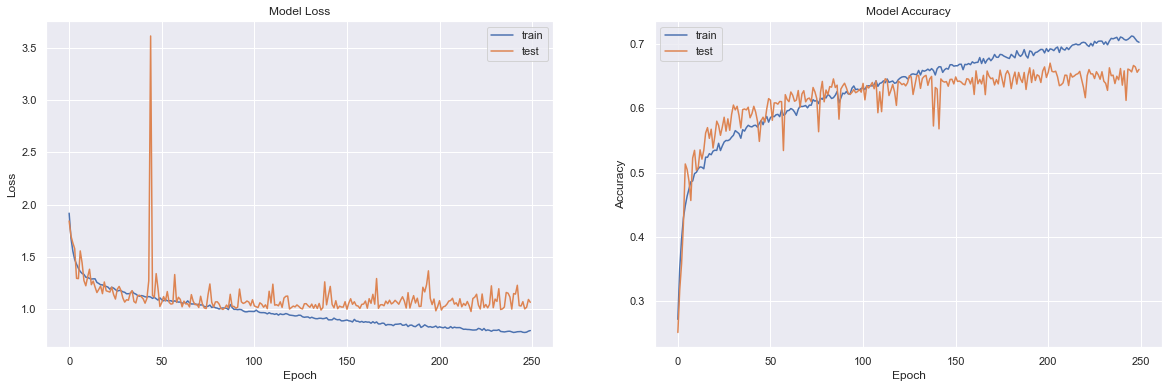

In [66]:
# SHOW HISTORY
plotHistory(history)

In [67]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaDB_ANN_best.h5', custom_objects={'DropBlock2D':DropBlock2D, 'AAConv': AAConv})
model.evaluate(test_it)

29/29 [==============================] - 2s 49ms/step - loss: 1.0475 - sparse_categorical_accuracy: 0.6520


[1.0474544763565063, 0.6519922018051147]

29/29 [==============================] - 2s 38ms/step


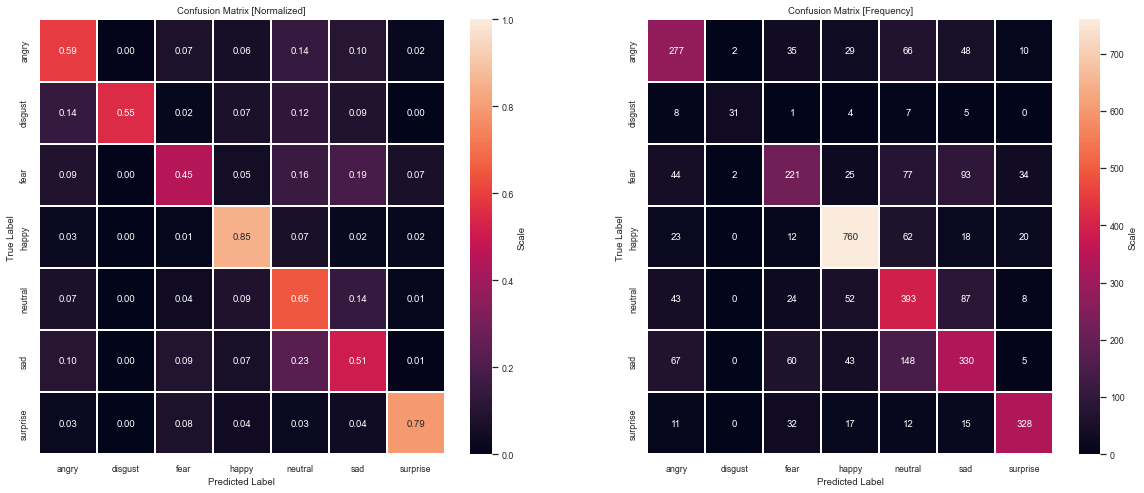

              precision    recall  f1-score   support

       angry       0.59      0.59      0.59       467
     disgust       0.89      0.55      0.68        56
        fear       0.57      0.45      0.50       496
       happy       0.82      0.85      0.83       895
     neutral       0.51      0.65      0.57       607
         sad       0.55      0.51      0.53       653
    surprise       0.81      0.79      0.80       415

    accuracy                           0.65      3589
   macro avg       0.68      0.63      0.64      3589
weighted avg       0.65      0.65      0.65      3589



In [68]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

### Simple CNN model + DropBlocks + Convolutional Block Attention Module

##### Metrics, loss, optimizer and checkpoints

In [69]:
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaDB_CBAM_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

##### Architecture

In [70]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaDB_CBAM')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(DropBlock2D(keep_prob=0.95,block_size=5, name='DROPBLOCK1'))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(DropBlock2D(keep_prob=0.85,block_size=4, name='DROPBLOCK2'))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name="CONV3"))
model.add(DropBlock2D(keep_prob=0.75,block_size=5, name='DROPBLOCK3'))
model.add(ChannelAttention(64, 16))
model.add(SpatialAttention(5))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaDB_CBAM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 DROPBLOCK1 (DropBlock2D)    (None, 48, 48, 32)        0         
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 23, 23, 32)        0         
                                                                 
 CONV2 (Conv2D)              (None, 23, 23, 32)        16416     
                                                                 
 DROPBLOCK2 (DropBlock2D)    (None, 23, 23, 32)        0         
                                                     

##### Training

In [71]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 1.9886 - sparse_categorical_accuracy: 0.2725
Epoch 1: val_loss improved from inf to 2.20105, saving model to Models/FER2013\KazadaDB_CBAM_best.h5
225/225 [==============================] - 23s 90ms/step - loss: 1.9886 - sparse_categorical_accuracy: 0.2725 - val_loss: 2.2010 - val_sparse_categorical_accuracy: 0.1856
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.7625 - sparse_categorical_accuracy: 0.3291
Epoch 2: val_loss improved from 2.20105 to 1.80420, saving model to Models/FER2013\KazadaDB_CBAM_best.h5
225/225 [==============================] - 20s 90ms/step - loss: 1.7625 - sparse_categorical_accuracy: 0.3291 - val_loss: 1.8042 - val_sparse_categorical_accuracy: 0.3037
Epoch 3/250
224/225 [============================>.] - ETA: 0s - loss: 1.6189 - sparse_categorical_accuracy: 0.3754
Epoch 3: val_loss improved from 1.80420 to 1.59845, saving model to Models/FER2013\KazadaDB_CBAM_best.h5

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.1809 - sparse_categorical_accuracy: 0.5486
Epoch 24: val_loss did not improve from 1.07436
225/225 [==============================] - 20s 88ms/step - loss: 1.1809 - sparse_categorical_accuracy: 0.5486 - val_loss: 1.0817 - val_sparse_categorical_accuracy: 0.5887
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.1855 - sparse_categorical_accuracy: 0.5501
Epoch 25: val_loss did not improve from 1.07436
225/225 [==============================] - 20s 88ms/step - loss: 1.1855 - sparse_categorical_accuracy: 0.5501 - val_loss: 1.1269 - val_sparse_categorical_accuracy: 0.5748
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.1785 - sparse_categorical_accuracy: 0.5538
Epoch 26: val_loss did not improve from 1.07436
225/225 [==============================] - 20s 88ms/step - loss: 1.1785 - sparse_categorical_accuracy: 0.5538 - val_loss: 1.0766 - val_sparse_categorical_accuracy:

Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 1.1013 - sparse_categorical_accuracy: 0.5808
Epoch 48: val_loss improved from 1.02023 to 1.01209, saving model to Models/FER2013\KazadaDB_CBAM_best.h5
225/225 [==============================] - 20s 89ms/step - loss: 1.1013 - sparse_categorical_accuracy: 0.5808 - val_loss: 1.0121 - val_sparse_categorical_accuracy: 0.6219
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 1.0956 - sparse_categorical_accuracy: 0.5841
Epoch 49: val_loss did not improve from 1.01209
225/225 [==============================] - 20s 88ms/step - loss: 1.0956 - sparse_categorical_accuracy: 0.5841 - val_loss: 1.0379 - val_sparse_categorical_accuracy: 0.6158
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 1.0947 - sparse_categorical_accuracy: 0.5851
Epoch 50: val_loss improved from 1.01209 to 1.01040, saving model to Models/FER2013\KazadaDB_CBAM_best.h5
225/225 [==============================] - 20s 

Epoch 72/250
225/225 [==============================] - ETA: 0s - loss: 1.0519 - sparse_categorical_accuracy: 0.6027
Epoch 72: val_loss did not improve from 0.98693
225/225 [==============================] - 20s 89ms/step - loss: 1.0519 - sparse_categorical_accuracy: 0.6027 - val_loss: 0.9961 - val_sparse_categorical_accuracy: 0.6303
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 1.0439 - sparse_categorical_accuracy: 0.6041
Epoch 73: val_loss did not improve from 0.98693
225/225 [==============================] - 20s 90ms/step - loss: 1.0439 - sparse_categorical_accuracy: 0.6041 - val_loss: 0.9975 - val_sparse_categorical_accuracy: 0.6266
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 1.0491 - sparse_categorical_accuracy: 0.6056
Epoch 74: val_loss did not improve from 0.98693
225/225 [==============================] - 20s 88ms/step - loss: 1.0491 - sparse_categorical_accuracy: 0.6056 - val_loss: 0.9959 - val_sparse_categorical_accuracy:

225/225 [==============================] - ETA: 0s - loss: 1.0146 - sparse_categorical_accuracy: 0.6150
Epoch 96: val_loss did not improve from 0.96830
225/225 [==============================] - 20s 88ms/step - loss: 1.0146 - sparse_categorical_accuracy: 0.6150 - val_loss: 0.9899 - val_sparse_categorical_accuracy: 0.6305
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 1.0069 - sparse_categorical_accuracy: 0.6201
Epoch 97: val_loss did not improve from 0.96830
225/225 [==============================] - 20s 88ms/step - loss: 1.0069 - sparse_categorical_accuracy: 0.6201 - val_loss: 1.0004 - val_sparse_categorical_accuracy: 0.6425
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 1.0125 - sparse_categorical_accuracy: 0.6175
Epoch 98: val_loss did not improve from 0.96830
225/225 [==============================] - 20s 88ms/step - loss: 1.0125 - sparse_categorical_accuracy: 0.6175 - val_loss: 0.9934 - val_sparse_categorical_accuracy: 0.6434
Epoch

225/225 [==============================] - ETA: 0s - loss: 0.9854 - sparse_categorical_accuracy: 0.6268
Epoch 120: val_loss did not improve from 0.94614
225/225 [==============================] - 20s 88ms/step - loss: 0.9854 - sparse_categorical_accuracy: 0.6268 - val_loss: 1.1502 - val_sparse_categorical_accuracy: 0.6219
Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.9863 - sparse_categorical_accuracy: 0.6290
Epoch 121: val_loss did not improve from 0.94614
225/225 [==============================] - 20s 88ms/step - loss: 0.9863 - sparse_categorical_accuracy: 0.6290 - val_loss: 1.1391 - val_sparse_categorical_accuracy: 0.6130
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.9884 - sparse_categorical_accuracy: 0.6292
Epoch 122: val_loss did not improve from 0.94614
225/225 [==============================] - 20s 88ms/step - loss: 0.9884 - sparse_categorical_accuracy: 0.6292 - val_loss: 1.1076 - val_sparse_categorical_accuracy: 0.6135


224/225 [============================>.] - ETA: 0s - loss: 0.9656 - sparse_categorical_accuracy: 0.6361
Epoch 144: val_loss did not improve from 0.94501
225/225 [==============================] - 21s 92ms/step - loss: 0.9656 - sparse_categorical_accuracy: 0.6362 - val_loss: 0.9674 - val_sparse_categorical_accuracy: 0.6467
Epoch 145/250
225/225 [==============================] - ETA: 0s - loss: 0.9597 - sparse_categorical_accuracy: 0.6375
Epoch 145: val_loss did not improve from 0.94501
225/225 [==============================] - 20s 88ms/step - loss: 0.9597 - sparse_categorical_accuracy: 0.6375 - val_loss: 1.0602 - val_sparse_categorical_accuracy: 0.6247
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.9601 - sparse_categorical_accuracy: 0.6384
Epoch 146: val_loss did not improve from 0.94501
225/225 [==============================] - 20s 89ms/step - loss: 0.9601 - sparse_categorical_accuracy: 0.6384 - val_loss: 0.9916 - val_sparse_categorical_accuracy: 0.6445


Epoch 168/250
225/225 [==============================] - ETA: 0s - loss: 0.9505 - sparse_categorical_accuracy: 0.6449
Epoch 168: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.9505 - sparse_categorical_accuracy: 0.6449 - val_loss: 0.9696 - val_sparse_categorical_accuracy: 0.6450
Epoch 169/250
225/225 [==============================] - ETA: 0s - loss: 0.9558 - sparse_categorical_accuracy: 0.6439
Epoch 169: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 89ms/step - loss: 0.9558 - sparse_categorical_accuracy: 0.6439 - val_loss: 0.9891 - val_sparse_categorical_accuracy: 0.6317
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.9429 - sparse_categorical_accuracy: 0.6452
Epoch 170: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.9429 - sparse_categorical_accuracy: 0.6452 - val_loss: 0.9640 - val_sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.9253 - sparse_categorical_accuracy: 0.6523
Epoch 192: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 87ms/step - loss: 0.9253 - sparse_categorical_accuracy: 0.6523 - val_loss: 0.9901 - val_sparse_categorical_accuracy: 0.6414
Epoch 193/250
225/225 [==============================] - ETA: 0s - loss: 0.9189 - sparse_categorical_accuracy: 0.6563
Epoch 193: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.9189 - sparse_categorical_accuracy: 0.6563 - val_loss: 0.9893 - val_sparse_categorical_accuracy: 0.6492
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.9292 - sparse_categorical_accuracy: 0.6523
Epoch 194: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.9292 - sparse_categorical_accuracy: 0.6523 - val_loss: 1.0370 - val_sparse_categorical_accuracy: 0.6381


225/225 [==============================] - ETA: 0s - loss: 0.9196 - sparse_categorical_accuracy: 0.6564
Epoch 216: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.9196 - sparse_categorical_accuracy: 0.6564 - val_loss: 0.9687 - val_sparse_categorical_accuracy: 0.6495
Epoch 217/250
225/225 [==============================] - ETA: 0s - loss: 0.9218 - sparse_categorical_accuracy: 0.6501
Epoch 217: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.9218 - sparse_categorical_accuracy: 0.6501 - val_loss: 1.0522 - val_sparse_categorical_accuracy: 0.6177
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.9109 - sparse_categorical_accuracy: 0.6606
Epoch 218: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.9109 - sparse_categorical_accuracy: 0.6606 - val_loss: 0.9856 - val_sparse_categorical_accuracy: 0.6339


225/225 [==============================] - ETA: 0s - loss: 0.8927 - sparse_categorical_accuracy: 0.6642
Epoch 240: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.8927 - sparse_categorical_accuracy: 0.6642 - val_loss: 1.0000 - val_sparse_categorical_accuracy: 0.6395
Epoch 241/250
225/225 [==============================] - ETA: 0s - loss: 0.8985 - sparse_categorical_accuracy: 0.6607
Epoch 241: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.8985 - sparse_categorical_accuracy: 0.6607 - val_loss: 1.1126 - val_sparse_categorical_accuracy: 0.6562
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.8919 - sparse_categorical_accuracy: 0.6652
Epoch 242: val_loss did not improve from 0.93501
225/225 [==============================] - 20s 88ms/step - loss: 0.8919 - sparse_categorical_accuracy: 0.6652 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.6626


##### History and performance

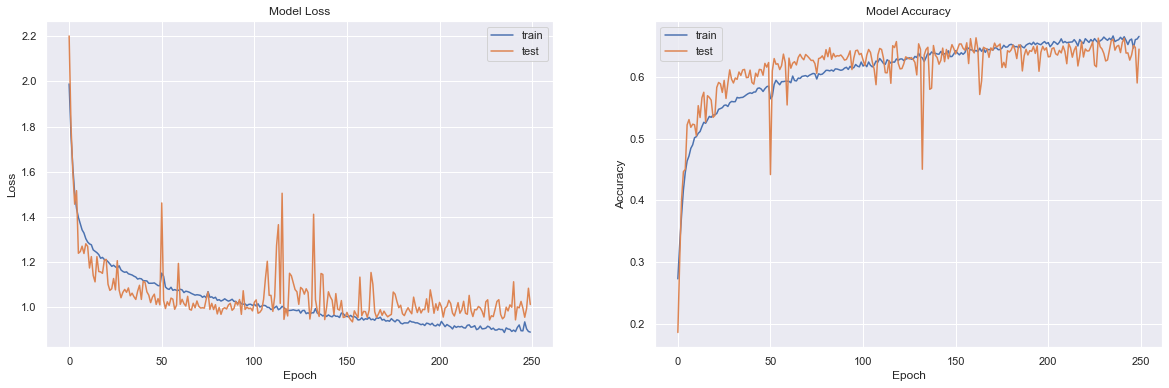

In [72]:
# SHOW HISTORY
plotHistory(history)

In [73]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaDB_CBAM_best.h5', custom_objects={'DropBlock2D':DropBlock2D, 'ChannelAttention':ChannelAttention,'SpatialAttention':SpatialAttention})
model.evaluate(test_it)

29/29 [==============================] - 2s 50ms/step - loss: 0.9995 - sparse_categorical_accuracy: 0.6261


[0.9994505643844604, 0.6260796785354614]

29/29 [==============================] - 2s 38ms/step


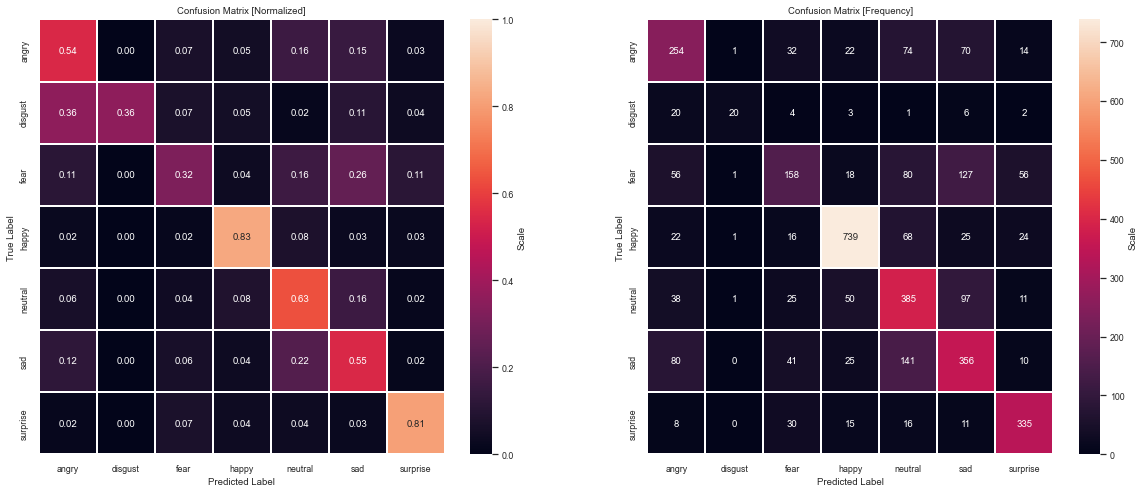

              precision    recall  f1-score   support

       angry       0.53      0.54      0.54       467
     disgust       0.83      0.36      0.50        56
        fear       0.52      0.32      0.39       496
       happy       0.85      0.83      0.84       895
     neutral       0.50      0.63      0.56       607
         sad       0.51      0.55      0.53       653
    surprise       0.74      0.81      0.77       415

    accuracy                           0.63      3589
   macro avg       0.64      0.58      0.59      3589
weighted avg       0.63      0.63      0.62      3589



In [74]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

### Simple CNN model + DropBlocks + Convolutional Block Attention Module (x3)

In [75]:
OPTIMIZER = Adam()
LOSS = SparseCategoricalCrossentropy()
METRIC = SparseCategoricalAccuracy()
CHECKPOINT = ModelCheckpoint('Models/'+DATASET+'/KazadaDB_3CBAM_best.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#EARLY_STOPPING = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [76]:
##DEFINE THE ARCHITECTURE
model = Sequential(name='KazadaDB_3CBAM')

#CONV1
model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=(48, 48, 1), name="CONV1"))
model.add(DropBlock2D(keep_prob=0.95,block_size=5, name='DROPBLOCK1'))
model.add(ChannelAttention(32, 16))
model.add(SpatialAttention(5))
model.add(BatchNormalization(name='BATCHNORM1'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL1"))

#CONV2
model.add(Conv2D(32, kernel_size=(4, 4), padding="same", activation='relu', name="CONV2"))
model.add(DropBlock2D(keep_prob=0.85,block_size=4, name='DROPBLOCK2'))
model.add(ChannelAttention(32, 16))
model.add(SpatialAttention(4))
model.add(BatchNormalization(name='BATCHNORM2'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL2"))

#CONV3
model.add(Conv2D(64, kernel_size=(5, 5), padding="same", activation='relu', name="CONV3"))
model.add(DropBlock2D(keep_prob=0.75,block_size=5, name='DROPBLOCK3'))
model.add(ChannelAttention(64, 16))
model.add(SpatialAttention(5))
model.add(BatchNormalization(name='BATCHNORM3'))
model.add(MaxPooling2D(pool_size=(3, 3),strides=(2, 2), name="MAXPOOL3"))

#CLASSIFICATION
model.add(Flatten(name='FLATTEN'))
model.add(Dense(1024, activation='relu',name='FC'))
model.add(Dropout(0.3, name='DROPOUT'))
model.add(BatchNormalization(name='BATCHNORMFC'))
model.add(Dense(N_CLASSES, activation='softmax',name='SOFTMAX'))

# SUMMARY
model.summary()

Model: "KazadaDB_3CBAM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 48, 48, 32)        832       
                                                                 
 DROPBLOCK1 (DropBlock2D)    (None, 48, 48, 32)        0         
                                                                 
 channel_attention_8 (Channe  (None, 48, 48, 32)       162       
 lAttention)                                                     
                                                                 
 spatial_attention_8 (Spatia  (None, 48, 48, 32)       50        
 lAttention)                                                     
                                                                 
 BATCHNORM1 (BatchNormalizat  (None, 48, 48, 32)       128       
 ion)                                                            
                                                    

In [77]:
# COMPILE AND TRAIN
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRIC)
history = model.fit(train_it, validation_data=val_it, epochs=EPOCHS, callbacks=[CHECKPOINT])

Epoch 1/250
225/225 [==============================] - ETA: 0s - loss: 1.9897 - sparse_categorical_accuracy: 0.2669
Epoch 1: val_loss improved from inf to 4.66464, saving model to Models/FER2013\KazadaDB_3CBAM_best.h5
225/225 [==============================] - 25s 93ms/step - loss: 1.9897 - sparse_categorical_accuracy: 0.2669 - val_loss: 4.6646 - val_sparse_categorical_accuracy: 0.1368
Epoch 2/250
225/225 [==============================] - ETA: 0s - loss: 1.6754 - sparse_categorical_accuracy: 0.3557
Epoch 2: val_loss improved from 4.66464 to 2.24682, saving model to Models/FER2013\KazadaDB_3CBAM_best.h5
225/225 [==============================] - 21s 94ms/step - loss: 1.6754 - sparse_categorical_accuracy: 0.3557 - val_loss: 2.2468 - val_sparse_categorical_accuracy: 0.2820
Epoch 3/250
225/225 [==============================] - ETA: 0s - loss: 1.5557 - sparse_categorical_accuracy: 0.4001
Epoch 3: val_loss improved from 2.24682 to 1.48778, saving model to Models/FER2013\KazadaDB_3CBAM_best

Epoch 24/250
225/225 [==============================] - ETA: 0s - loss: 1.1410 - sparse_categorical_accuracy: 0.5621
Epoch 24: val_loss did not improve from 1.07735
225/225 [==============================] - 21s 91ms/step - loss: 1.1410 - sparse_categorical_accuracy: 0.5621 - val_loss: 1.6267 - val_sparse_categorical_accuracy: 0.5032
Epoch 25/250
225/225 [==============================] - ETA: 0s - loss: 1.1365 - sparse_categorical_accuracy: 0.5669
Epoch 25: val_loss did not improve from 1.07735
225/225 [==============================] - 21s 91ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.5669 - val_loss: 1.1644 - val_sparse_categorical_accuracy: 0.5667
Epoch 26/250
225/225 [==============================] - ETA: 0s - loss: 1.1349 - sparse_categorical_accuracy: 0.5716
Epoch 26: val_loss improved from 1.07735 to 1.04416, saving model to Models/FER2013\KazadaDB_3CBAM_best.h5
225/225 [==============================] - 21s 91ms/step - loss: 1.1349 - sparse_categorical_accuracy: 0

Epoch 48/250
225/225 [==============================] - ETA: 0s - loss: 1.0470 - sparse_categorical_accuracy: 0.6010
Epoch 48: val_loss did not improve from 0.99675
225/225 [==============================] - 21s 91ms/step - loss: 1.0470 - sparse_categorical_accuracy: 0.6010 - val_loss: 1.0006 - val_sparse_categorical_accuracy: 0.6339
Epoch 49/250
225/225 [==============================] - ETA: 0s - loss: 1.0558 - sparse_categorical_accuracy: 0.6006
Epoch 49: val_loss did not improve from 0.99675
225/225 [==============================] - 21s 93ms/step - loss: 1.0558 - sparse_categorical_accuracy: 0.6006 - val_loss: 1.0648 - val_sparse_categorical_accuracy: 0.5854
Epoch 50/250
225/225 [==============================] - ETA: 0s - loss: 1.0486 - sparse_categorical_accuracy: 0.6005
Epoch 50: val_loss did not improve from 0.99675
225/225 [==============================] - 20s 91ms/step - loss: 1.0486 - sparse_categorical_accuracy: 0.6005 - val_loss: 1.0034 - val_sparse_categorical_accuracy:

Epoch 72/250
225/225 [==============================] - ETA: 0s - loss: 0.9863 - sparse_categorical_accuracy: 0.6264
Epoch 72: val_loss improved from 0.96220 to 0.95694, saving model to Models/FER2013\KazadaDB_3CBAM_best.h5
225/225 [==============================] - 21s 92ms/step - loss: 0.9863 - sparse_categorical_accuracy: 0.6264 - val_loss: 0.9569 - val_sparse_categorical_accuracy: 0.6422
Epoch 73/250
225/225 [==============================] - ETA: 0s - loss: 0.9941 - sparse_categorical_accuracy: 0.6264
Epoch 73: val_loss did not improve from 0.95694
225/225 [==============================] - 21s 91ms/step - loss: 0.9941 - sparse_categorical_accuracy: 0.6264 - val_loss: 1.0198 - val_sparse_categorical_accuracy: 0.6197
Epoch 74/250
225/225 [==============================] - ETA: 0s - loss: 0.9946 - sparse_categorical_accuracy: 0.6250
Epoch 74: val_loss did not improve from 0.95694
225/225 [==============================] - 21s 91ms/step - loss: 0.9946 - sparse_categorical_accuracy: 0

Epoch 96/250
225/225 [==============================] - ETA: 0s - loss: 0.9585 - sparse_categorical_accuracy: 0.6396
Epoch 96: val_loss did not improve from 0.93534
225/225 [==============================] - 21s 91ms/step - loss: 0.9585 - sparse_categorical_accuracy: 0.6396 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.6191
Epoch 97/250
225/225 [==============================] - ETA: 0s - loss: 0.9594 - sparse_categorical_accuracy: 0.6400
Epoch 97: val_loss did not improve from 0.93534
225/225 [==============================] - 21s 92ms/step - loss: 0.9594 - sparse_categorical_accuracy: 0.6400 - val_loss: 0.9422 - val_sparse_categorical_accuracy: 0.6464
Epoch 98/250
225/225 [==============================] - ETA: 0s - loss: 0.9528 - sparse_categorical_accuracy: 0.6434
Epoch 98: val_loss did not improve from 0.93534
225/225 [==============================] - 21s 91ms/step - loss: 0.9528 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.9861 - val_sparse_categorical_accuracy:

Epoch 120/250
225/225 [==============================] - ETA: 0s - loss: 0.9324 - sparse_categorical_accuracy: 0.6501
Epoch 120: val_loss did not improve from 0.93222
225/225 [==============================] - 21s 91ms/step - loss: 0.9324 - sparse_categorical_accuracy: 0.6501 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.6578
Epoch 121/250
225/225 [==============================] - ETA: 0s - loss: 0.9161 - sparse_categorical_accuracy: 0.6548
Epoch 121: val_loss did not improve from 0.93222
225/225 [==============================] - 21s 91ms/step - loss: 0.9161 - sparse_categorical_accuracy: 0.6548 - val_loss: 0.9563 - val_sparse_categorical_accuracy: 0.6445
Epoch 122/250
225/225 [==============================] - ETA: 0s - loss: 0.9169 - sparse_categorical_accuracy: 0.6525
Epoch 122: val_loss did not improve from 0.93222
225/225 [==============================] - 21s 91ms/step - loss: 0.9169 - sparse_categorical_accuracy: 0.6525 - val_loss: 0.9388 - val_sparse_categorical_acc

Epoch 144/250
225/225 [==============================] - ETA: 0s - loss: 0.9129 - sparse_categorical_accuracy: 0.6605
Epoch 144: val_loss did not improve from 0.91762
225/225 [==============================] - 21s 91ms/step - loss: 0.9129 - sparse_categorical_accuracy: 0.6605 - val_loss: 0.9355 - val_sparse_categorical_accuracy: 0.6590
Epoch 145/250
225/225 [==============================] - ETA: 0s - loss: 0.9003 - sparse_categorical_accuracy: 0.6608
Epoch 145: val_loss did not improve from 0.91762
225/225 [==============================] - 21s 91ms/step - loss: 0.9003 - sparse_categorical_accuracy: 0.6608 - val_loss: 0.9635 - val_sparse_categorical_accuracy: 0.6578
Epoch 146/250
225/225 [==============================] - ETA: 0s - loss: 0.8942 - sparse_categorical_accuracy: 0.6635
Epoch 146: val_loss did not improve from 0.91762
225/225 [==============================] - 21s 91ms/step - loss: 0.8942 - sparse_categorical_accuracy: 0.6635 - val_loss: 0.9322 - val_sparse_categorical_acc

225/225 [==============================] - ETA: 0s - loss: 0.8663 - sparse_categorical_accuracy: 0.6761
Epoch 168: val_loss did not improve from 0.91762
225/225 [==============================] - 21s 92ms/step - loss: 0.8663 - sparse_categorical_accuracy: 0.6761 - val_loss: 0.9627 - val_sparse_categorical_accuracy: 0.6525
Epoch 169/250
225/225 [==============================] - ETA: 0s - loss: 0.8714 - sparse_categorical_accuracy: 0.6734
Epoch 169: val_loss did not improve from 0.91762
225/225 [==============================] - 21s 92ms/step - loss: 0.8714 - sparse_categorical_accuracy: 0.6734 - val_loss: 0.9797 - val_sparse_categorical_accuracy: 0.6617
Epoch 170/250
225/225 [==============================] - ETA: 0s - loss: 0.8688 - sparse_categorical_accuracy: 0.6725
Epoch 170: val_loss did not improve from 0.91762
225/225 [==============================] - 21s 91ms/step - loss: 0.8688 - sparse_categorical_accuracy: 0.6725 - val_loss: 0.9705 - val_sparse_categorical_accuracy: 0.6486


225/225 [==============================] - ETA: 0s - loss: 0.8452 - sparse_categorical_accuracy: 0.6826
Epoch 192: val_loss did not improve from 0.91345
225/225 [==============================] - 21s 91ms/step - loss: 0.8452 - sparse_categorical_accuracy: 0.6826 - val_loss: 0.9741 - val_sparse_categorical_accuracy: 0.6629
Epoch 193/250
225/225 [==============================] - ETA: 0s - loss: 0.8489 - sparse_categorical_accuracy: 0.6818
Epoch 193: val_loss did not improve from 0.91345
225/225 [==============================] - 21s 91ms/step - loss: 0.8489 - sparse_categorical_accuracy: 0.6818 - val_loss: 0.9207 - val_sparse_categorical_accuracy: 0.6737
Epoch 194/250
225/225 [==============================] - ETA: 0s - loss: 0.8493 - sparse_categorical_accuracy: 0.6836
Epoch 194: val_loss did not improve from 0.91345
225/225 [==============================] - 21s 91ms/step - loss: 0.8493 - sparse_categorical_accuracy: 0.6836 - val_loss: 0.9905 - val_sparse_categorical_accuracy: 0.6517


225/225 [==============================] - ETA: 0s - loss: 0.8295 - sparse_categorical_accuracy: 0.6881
Epoch 216: val_loss did not improve from 0.90330
225/225 [==============================] - 21s 91ms/step - loss: 0.8295 - sparse_categorical_accuracy: 0.6881 - val_loss: 0.9565 - val_sparse_categorical_accuracy: 0.6615
Epoch 217/250
225/225 [==============================] - ETA: 0s - loss: 0.8270 - sparse_categorical_accuracy: 0.6920
Epoch 217: val_loss did not improve from 0.90330
225/225 [==============================] - 21s 92ms/step - loss: 0.8270 - sparse_categorical_accuracy: 0.6920 - val_loss: 0.9864 - val_sparse_categorical_accuracy: 0.6434
Epoch 218/250
225/225 [==============================] - ETA: 0s - loss: 0.8251 - sparse_categorical_accuracy: 0.6920
Epoch 218: val_loss did not improve from 0.90330
225/225 [==============================] - 21s 91ms/step - loss: 0.8251 - sparse_categorical_accuracy: 0.6920 - val_loss: 0.9400 - val_sparse_categorical_accuracy: 0.6570


225/225 [==============================] - ETA: 0s - loss: 0.8116 - sparse_categorical_accuracy: 0.6943
Epoch 240: val_loss did not improve from 0.90330
225/225 [==============================] - 21s 91ms/step - loss: 0.8116 - sparse_categorical_accuracy: 0.6943 - val_loss: 0.9542 - val_sparse_categorical_accuracy: 0.6651
Epoch 241/250
225/225 [==============================] - ETA: 0s - loss: 0.8206 - sparse_categorical_accuracy: 0.6919
Epoch 241: val_loss did not improve from 0.90330
225/225 [==============================] - 20s 88ms/step - loss: 0.8206 - sparse_categorical_accuracy: 0.6919 - val_loss: 0.9616 - val_sparse_categorical_accuracy: 0.6670
Epoch 242/250
225/225 [==============================] - ETA: 0s - loss: 0.8191 - sparse_categorical_accuracy: 0.6949
Epoch 242: val_loss did not improve from 0.90330
225/225 [==============================] - 21s 91ms/step - loss: 0.8191 - sparse_categorical_accuracy: 0.6949 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.6617


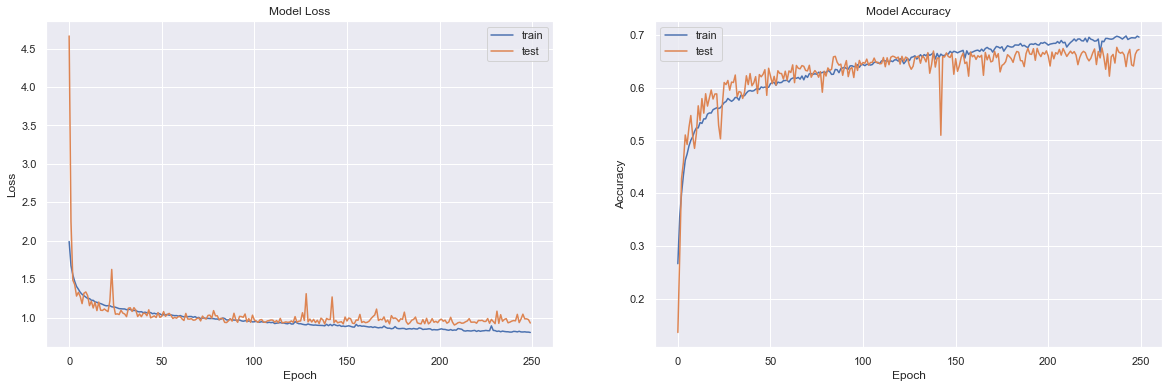

In [78]:
# SHOW HISTORY
plotHistory(history)

In [79]:
# LOADING THE BEST MODEL AND PERFORMING EVALUATION
model = load_model('Models/'+DATASET+'/KazadaDB_3CBAM_best.h5', custom_objects={'DropBlock2D':DropBlock2D, 'ChannelAttention':ChannelAttention,'SpatialAttention':SpatialAttention})
model.evaluate(test_it)

29/29 [==============================] - 2s 44ms/step - loss: 1.0163 - sparse_categorical_accuracy: 0.6617


[1.0162899494171143, 0.661744236946106]

29/29 [==============================] - 2s 40ms/step


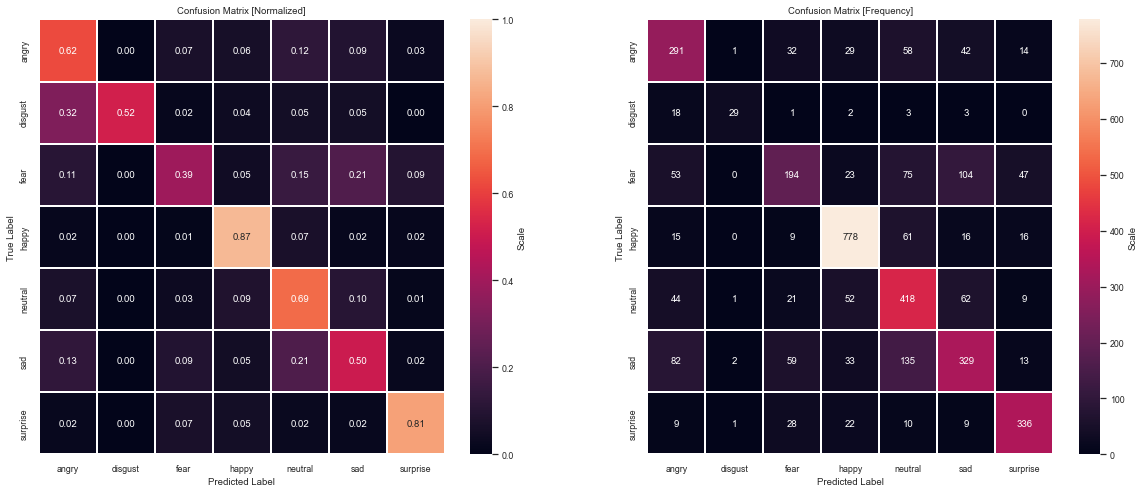

              precision    recall  f1-score   support

       angry       0.57      0.62      0.59       467
     disgust       0.85      0.52      0.64        56
        fear       0.56      0.39      0.46       496
       happy       0.83      0.87      0.85       895
     neutral       0.55      0.69      0.61       607
         sad       0.58      0.50      0.54       653
    surprise       0.77      0.81      0.79       415

    accuracy                           0.66      3589
   macro avg       0.67      0.63      0.64      3589
weighted avg       0.66      0.66      0.66      3589



In [80]:
# CONFUSION MATRIX AND REPORT
predictions = model.predict(test_it)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_it.classes
class_labels = list(test_it.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
print(report)

#### Gradcam++ models with DropBlocks

In [81]:
modelCNN = load_model('Models/'+DATASET+'/KazadaDropBlock_best.h5', custom_objects={'DropBlock2D':DropBlock2D})
modelANN = load_model('Models/'+DATASET+'/KazadaDB_ANN_best.h5', custom_objects={'DropBlock2D':DropBlock2D,'AAConv': AAConv})
modelCBAM = load_model('Models/'+DATASET+'/KazadaDB_CBAM_best.h5', custom_objects={'DropBlock2D':DropBlock2D,'ChannelAttention':ChannelAttention,'SpatialAttention':SpatialAttention})
model3CBAM = load_model('Models/'+DATASET+'/KazadaDB_3CBAM_best.h5', custom_objects={'DropBlock2D':DropBlock2D,'ChannelAttention':ChannelAttention,'SpatialAttention':SpatialAttention})

In [82]:
### CNN CAM
y_pred_CNN = modelCNN.predict(X_test)
y_pred_CNN = np.argmax(y_pred_CNN, axis=1)
titles = makeTitle(y_pred_CNN[:N_IMAGES], y_test[:N_IMAGES], class_names_dict)
gradcam_CNN = GradcamPlusPlus(modelCNN, model_modifier=replace2linear, clone=True)
score_CNN = CategoricalScore(list(y_pred_CNN[:N_IMAGES]))
cam_CNN = gradcam_CNN(score_CNN, images, penultimate_layer=-1)

### ANN CAM
y_pred_ANN = modelANN.predict(X_test)
y_pred_ANN = np.argmax(y_pred_ANN, axis=1)
titles = makeTitle(y_pred_ANN[:N_IMAGES], y_test[:N_IMAGES], class_names_dict)
gradcam_ANN = GradcamPlusPlus(modelANN, model_modifier=replace2linear, clone=True)
score_ANN = CategoricalScore(list(y_pred_ANN[:N_IMAGES]))
cam_ANN = gradcam_ANN(score_ANN, images, penultimate_layer=-1)

### CBAM CAM
y_pred_CBAM = modelCBAM.predict(X_test)
y_pred_CBAM = np.argmax(y_pred_CBAM, axis=1)
titles = makeTitle(y_pred_CBAM[:N_IMAGES], y_test[:N_IMAGES], class_names_dict)
gradcam_CBAM = GradcamPlusPlus(modelCBAM, model_modifier=replace2linear, clone=True)
score_CBAM = CategoricalScore(list(y_pred_CBAM[:N_IMAGES]))
cam_CBAM = gradcam_CBAM(score_CBAM, images, penultimate_layer=-1)

### 3CBAM CAM
y_pred_3CBAM = model3CBAM.predict(X_test)
y_pred_3CBAM = np.argmax(y_pred_3CBAM, axis=1)
titles = makeTitle(y_pred_3CBAM[:N_IMAGES], y_test[:N_IMAGES], class_names_dict)
gradcam_3CBAM = GradcamPlusPlus(model3CBAM, model_modifier=replace2linear, clone=True)
score_3CBAM = CategoricalScore(list(y_pred_3CBAM[:N_IMAGES]))
cam_3CBAM = gradcam_3CBAM(score_3CBAM, images, penultimate_layer=-1)

4/4 [==============================] - 1s 12ms/step


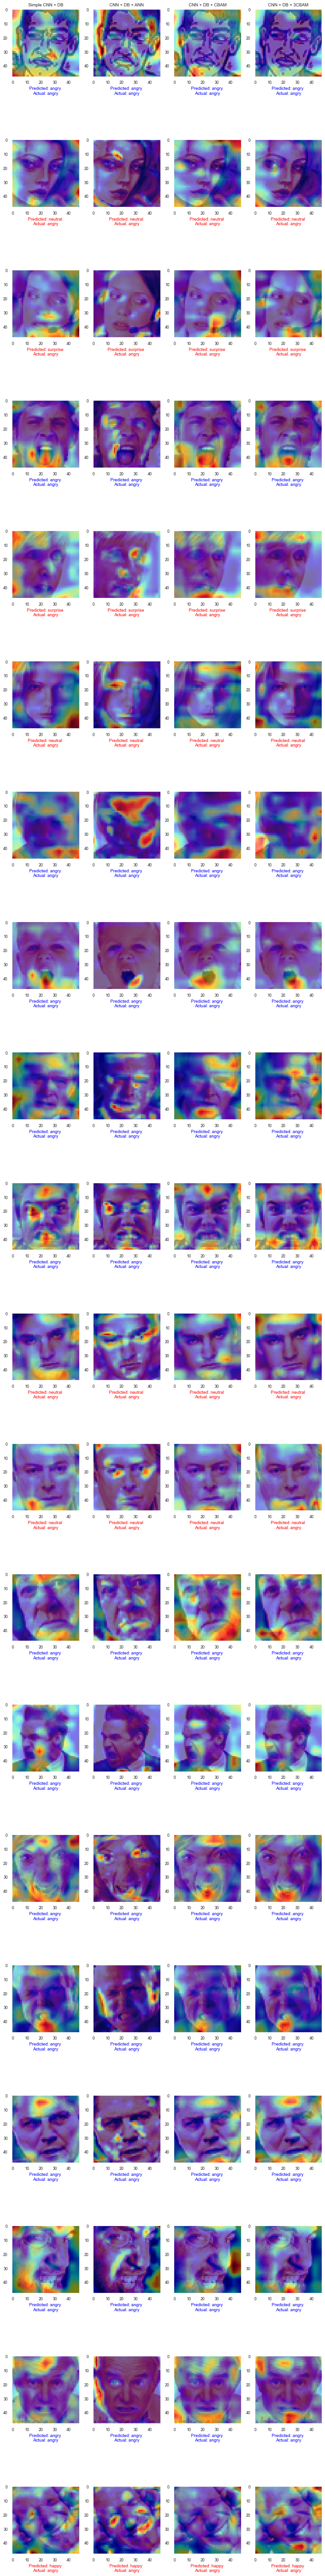

In [83]:
# Render
f, axes = plt.subplots(nrows=N_IMAGES, ncols=4, figsize=(10, 4*N_IMAGES))
axes[0][0].set_title('Simple CNN + DB')
axes[0][1].set_title('CNN + DB + ANN')
axes[0][2].set_title('CNN + DB + CBAM')
axes[0][3].set_title('CNN + DB + 3CBAM')
for i, title in enumerate(titles):
    #1st model
    heatmap = np.uint8(cm.jet(cam_CNN[i])[..., :3] * 255)
    axes[i][0].set_xlabel(title[0], color=('blue' if title[1] == True else 'red'))
    axes[i][0].imshow(images[i])
    axes[i][0].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[i][0].axis('on')
    axes[i][0].grid(b=None)
    #2nd model
    heatmap_ANN = np.uint8(cm.jet(cam_ANN[i])[..., :3] * 255)
    axes[i][1].set_xlabel(title[0], color=('blue' if title[1] == True else 'red'))
    axes[i][1].imshow(images[i])
    axes[i][1].imshow(heatmap_ANN, cmap='jet', alpha=0.5)
    axes[i][1].axis('on')
    axes[i][1].grid(b=None)
    #3rd model
    heatmap_CBAM = np.uint8(cm.jet(cam_CBAM[i])[..., :3] * 255)
    axes[i][2].set_xlabel(title[0], color=('blue' if title[1] == True else 'red'))
    axes[i][2].imshow(images[i])
    axes[i][2].imshow(heatmap_CBAM, cmap='jet', alpha=0.5)
    axes[i][2].axis('on')
    axes[i][2].grid(b=None)
    #4rd model
    heatmap_3CBAM = np.uint8(cm.jet(cam_3CBAM[i])[..., :3] * 255)
    axes[i][3].set_xlabel(title[0], color=('blue' if title[1] == True else 'red'))
    axes[i][3].imshow(images[i])
    axes[i][3].imshow(heatmap_3CBAM, cmap='jet', alpha=0.5)
    axes[i][3].axis('on')
    axes[i][3].grid(b=None)

plt.tight_layout()
plt.show()

### Results

| **Model**               	| **Accuracy** 	|
|-------------------------	|--------------	|
| 3CNN                    	| 61.69%       	|
| 2CNN + 1AACN            	| 62.05%       	|
| 3CNN + 1CBAM            	| 63.11%       	|
| 3CNN / with DBs         	| 65.12%       	|
| 2CNN + 1AACN / with DBs 	| 65.20%       	|
| 3CNN + 1CBAM / with DBs 	| 62.61%       	|
| **3CNN + 3CBAM /with DBs**  	| **66.17%**       	|